## Notebook set-up

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
import scipy.stats as stats
from scipy.stats import zscore
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
import statsmodels.api as sm
from statsmodels.graphics.boxplots import beanplot
from scipy.stats import rankdata


In [3]:
import usv_library as ul
import usv_class as uc
from usv_class import USV

### Functions to load CSVs into dataframes for processing

In [4]:
# Helper function to read CSV files with unknown encoding safely
def safe_read_csv(path):
    with open(path, 'rb') as f:
        result = chardet.detect(f.read(50000))
    return pd.read_csv(path, encoding=result['encoding'])

In [5]:
# Functions to load CSVs into dataframes for processing
def load_csvs_from_subdirs(parent_dir):
    usv_data_dfs = {}
    session_data_dfs = {}

    for subdir in os.listdir(parent_dir):
        subdir_path = os.path.join(parent_dir, subdir)
        condition_list = subdir.strip().split('_')
        free_rat, restrainer_rat = condition_list[0][:4].lower(), condition_list[0][4:].lower()
        condition = condition_list[3]
        # Only process directories
        if os.path.isdir(subdir_path):
            # Look for CSV files in this subfolder
            for file in os.listdir(subdir_path):
                if file.endswith("USV_data.csv") & (not file.startswith('.')) :
                    csv_path = os.path.join(subdir_path, file)
                    usv_df = safe_read_csv(csv_path)
                    usv_df['filename'] = file
                    usv_df['free_rat'] = free_rat
                    usv_df['restrainer_rat'] = restrainer_rat
                    usv_df['condition'] = condition
                    usv_data_dfs[file] = usv_df
                elif file.endswith("session_data.csv"):
                    csv_path = os.path.join(subdir_path, file)
                    session_df = safe_read_csv(csv_path)
                    session_df['filename'] = file
                    session_df['free_rat'] = free_rat
                    session_df['restrainer_rat'] = restrainer_rat
                    session_df['condition'] = condition
                    session_data_dfs[file] = session_df
    return usv_data_dfs, session_data_dfs

In [6]:
# === No longer needed functions === #
 
"""

# Creates to fix preexisting CSVs by adding columns and removing unnamed index column (no longer needed)
def fix_csvs(parent_dir):
    for subdir in os.listdir(parent_dir):
        subdir_path = os.path.join(parent_dir, subdir)
        new_csv = ul.add_cols_to_existing(subdir_path)
        new_csv.drop(columns=["Unnamed: 0"], inplace=True)
        new_csv.to_csv(f'{subdir_path}\{subdir}_USV_data.csv', index=False)

# Function to extract session info from USV_data CSV (no longer needed)
def session_info(filepath):
    usv_df = pd.read_csv(filepath)
    session_data = usv_df.groupby(by=['trial_num', 'trial_start'])[['lever_press', 'open_latency']].mean().reset_index()
    calls_per_trial = (usv_df[usv_df['25_kHz_call'] == 1]
                        .groupby(by=['trial_num', 'before_open'])['label']
                        .count().reset_index())
    cpt_dict = {t: (calls_per_trial[calls_per_trial['trial_num'] == t].values 
                    if t in calls_per_trial['trial_num'].values else ['None'])
                    for t in np.arange(1, 6)}

    session_data['calls_before'] = False
    session_data['calls_after'] = False

    for t, arr in cpt_dict.items():
        if arr is None or len(arr) == 0:
            continue

        # Convert to a flat list of strings
        values = [str(x) for row in arr for x in row]

        # Check membership
        calls_before = 'True' in values
        calls_after = 'False' in values

        # Assign to all rows with that trial_num
        session_data.loc[session_data['trial_num'] == t, 'calls_before'] = calls_before
        session_data.loc[session_data['trial_num'] == t, 'calls_after'] = calls_after  

    return session_data

# Function to add session data CSVs based on USV_data CSVs (no longer needed)
def add_session_data(parent_dir):
    for subdir in os.listdir(parent_dir):
        subdir_path = os.path.join(parent_dir, subdir)
        for file in os.listdir(subdir_path):
            if file.endswith("_USV_data.csv"):
                csv_path = os.path.join(subdir_path, file)
                session_data = session_info(csv_path)
                filename = file.replace("_USV_data.csv", "_session_data.csv")
                session_data.to_csv(filename, index=False)
                break

"""

<>:3: SyntaxWarning: invalid escape sequence '\{'
<>:3: SyntaxWarning: invalid escape sequence '\{'
/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_15444/2116184235.py:3: SyntaxWarning: invalid escape sequence '\{'
  """


'\n\n# Creates to fix preexisting CSVs by adding columns and removing unnamed index column (no longer needed)\ndef fix_csvs(parent_dir):\n    for subdir in os.listdir(parent_dir):\n        subdir_path = os.path.join(parent_dir, subdir)\n        new_csv = ul.add_cols_to_existing(subdir_path)\n        new_csv.drop(columns=["Unnamed: 0"], inplace=True)\n        new_csv.to_csv(f\'{subdir_path}\\{subdir}_USV_data.csv\', index=False)\n\n# Function to extract session info from USV_data CSV (no longer needed)\ndef session_info(filepath):\n    usv_df = pd.read_csv(filepath)\n    session_data = usv_df.groupby(by=[\'trial_num\', \'trial_start\'])[[\'lever_press\', \'open_latency\']].mean().reset_index()\n    calls_per_trial = (usv_df[usv_df[\'25_kHz_call\'] == 1]\n                        .groupby(by=[\'trial_num\', \'before_open\'])[\'label\']\n                        .count().reset_index())\n    cpt_dict = {t: (calls_per_trial[calls_per_trial[\'trial_num\'] == t].values \n                    if 

### Functions to compute rolling call densities

In [7]:
def rolling_call_density(event_times, window_size, bin_size, session_length):
    """
    Compute rolling event density using a time-centered Series.
    
    Parameters
    ----------
    event_times : array-like
        Timestamps (in seconds) of event occurrences.
    window_size : float
        Width of the rolling window in seconds.
    bin_size : float
        Size of time bins in seconds.
    session_length : float
        Total length of the session in seconds.
    
    Returns
    -------
    pd.Series
        Time-indexed rolling density (events per second).
    """
    
    # 1. Define time bins and centers
    bins = np.arange(0, session_length + bin_size, bin_size)
    time_centers = bins[:-1] + bin_size / 2

    # 2. Count events per bin
    counts, _ = np.histogram(event_times, bins=bins)

    # 3. Make a pandas Series indexed by time centers
    count_series = pd.Series(counts, index=time_centers)

    # 4. Compute rolling density (past-only / left-aligned)
    window_bins = int(window_size / bin_size)
    density_series = count_series.rolling(window=window_bins, min_periods=1).sum() / window_size

    return density_series

In [8]:
def get_rolling_density(df, window_size, bin_size, session_length=240):
    df_25kHz = df[df['25_kHz_call'] == 1].copy()
    df_25kHz['before_open'] = df_25kHz['before_open'].fillna('No Open').astype(str)
    df_25kHz['relative_start'] = df_25kHz['start'] - df_25kHz['trial_start']
    df_25kHz['open_latency'] = df_25kHz['open_latency'].fillna(0)
    rolling_call_densities = {}
    
    for trial in df_25kHz['trial_num'].unique():
        trial_df = df_25kHz[df_25kHz['trial_num'] == trial]
        open_latency = trial_df['open_latency'].iloc[0]
        density_series = rolling_call_density(
            trial_df['relative_start'].values,
            window_size,
            bin_size,
            session_length
        )

        open_latency_range = (open_latency, open_latency + window_size)
        
        if open_latency == 0:
            open_latency_range = (0, 0)

        rolling_call_densities[trial] = (open_latency, open_latency_range, density_series)

    return rolling_call_densities

In [9]:
def get_rolling_density_df(usv_df_dict, window_size, bin_size, session_length=240):
    # Create an empty list to hold all rows
    all_rows = []

    for session_name, df in usv_df_dict.items():
        session_dict = get_rolling_density(df, window_size, bin_size)
        
        for trial_num, (open_latency, open_latency_range, rolling_density) in session_dict.items():
            # if open_latency == 0:
            #     continue
            
            time_centers = rolling_density.index.values
            densities = rolling_density.values

            # Use the open_latency_range to flag bins
            # Assume open_latency_range = (start, end)
            start, end = open_latency_range
            open_mask = (time_centers >= start) & (time_centers <= end)
            time_vs_open = ['No Open' if open_latency == 0 else
                            'During' if mask else 
                            'Before' if time < open_latency else 
                            'After' for time, mask in zip(time_centers, open_mask)]

            trial_df = pd.DataFrame({
                'session': session_name,
                'trial': trial_num,
                'time': time_centers,
                'density': densities,
                'open_bin': open_mask,
                'time_vs_open': time_vs_open
            })

            trial_df['open_latency'] = open_latency
            trial_df['open_latency_range'] = str(open_latency_range)
            trial_df['density_minmax'] = (trial_df['density'] - trial_df['density'].min()) / (trial_df['density'].max() - trial_df['density'].min())
            trial_df['density_zscore'] = zscore(trial_df['density'], nan_policy='omit')
            trial_df['density_ranked'] = rankdata(trial_df['density'], method='average') / (len(trial_df['density']) + 1)

            all_rows.append(trial_df)

    # Combine all trials
    df_all_bins = pd.concat(all_rows, ignore_index=True)
    return df_all_bins

In [10]:
def compute_mannwhitneyu_stats(rolling_density_df):    
    # Prepare a list to store results
    results = []

    # Loop over sessions
    for session_name, session_df in rolling_density_df.groupby('filename'):
        
        # Session-level test (all trials pooled)
        true_bins = session_df.loc[session_df.open_bin, 'density_zscore']
        false_bins = session_df.loc[~session_df.open_bin, 'density_zscore']
        
        if len(true_bins) > 0 and len(false_bins) > 0:
            u_stat, p_val = mannwhitneyu(true_bins, false_bins, alternative='greater')
            # Compute rank-biserial correlation as effect size
            n1 = len(true_bins)
            n2 = len(false_bins)
            rbc = 1 - (2 * u_stat) / (n1 * n2)
        else:
            u_stat, p_val, rbc = None, None, None
        
        results.append({
            'session': session_name,
            'trial': 'all',
            'U': u_stat,
            'p_value': p_val,
            'rank_biserial_corr': rbc
        })
        
        # Trial-level tests
        for trial_num, trial_df in session_df.groupby('trial_num'):
            true_bins = trial_df.loc[trial_df.open_bin, 'density_zscore']
            false_bins = trial_df.loc[~trial_df.open_bin, 'density_zscore']
            
            if len(true_bins) > 0 and len(false_bins) > 0:
                u_stat, p_val = mannwhitneyu(true_bins, false_bins, alternative='two-sided')
                n1 = len(true_bins)
                n2 = len(false_bins)
                rbc = 1 - (2 * u_stat) / (n1 * n2)
            else:
                u_stat, p_val, rbc = None, None, None
            
            results.append({
                'session': session_name,
                'trial': trial_num,
                'U': u_stat,
                'p_value': p_val,
                'rank_biserial_corr': rbc
            })

    # Combine into a DataFrame
    df_stats = pd.DataFrame(results)
    return df_stats

### Function to create call density dataframe

In [11]:
# Helper function to calculate call density based on before_open status

def get_density(row):
    before_open = row['before_open']
    count = row['count']
    open_latency = row['open_latency']
    if before_open == 'True':
        return count / open_latency
    elif before_open == 'False':
        return count / (240-open_latency)
    elif before_open == 'None':
        return count / 240

## Create Dataframes

In [12]:
# Create dictionaries of dataframes from CSVs -- USV_data and session_data

parent_directory = r"/Volumes/SOPHIEDRIVE/25kHz/25kHz_USV_data"
usv_dataframes, session_dataframes = load_csvs_from_subdirs(parent_directory)

In [13]:
# Creates combined dataframes from USV_data and session_data CSVs

usv_dataframe = pd.DataFrame()
for file, df in usv_dataframes.items():
    usv_dataframe = pd.concat([usv_dataframe, df], ignore_index=True)

usv_dataframe = usv_dataframe[usv_dataframe['25_kHz_call'] == 1].drop(columns=['Unnamed: 0'], errors='ignore')
usv_dataframe['before_open'] = usv_dataframe['before_open'].fillna('No Open').astype(str)
usv_dataframe['condition'] = usv_dataframe['condition'].replace('Cagemate2', 'Cagemate')

session_info_dataframe = pd.DataFrame()
for file, df in session_dataframes.items():
    session_info_dataframe = pd.concat([session_info_dataframe, df], ignore_index=True)

session_info_dataframe.drop(columns=['Unnamed: 0'], errors='ignore', inplace=True)
session_info_dataframe['lever_press'] = (session_info_dataframe['lever_press'].fillna(0) 
                                         + session_info_dataframe['open_time'].astype(float).fillna(0))
session_info_dataframe['condition'] = session_info_dataframe['condition'].replace('Cagemate2', 'Cagemate')
session_info_dataframe.drop(columns=['open_time'], inplace=True, errors='ignore')
session_info_dataframe['open_tf'] = session_info_dataframe['open_latency'].apply(lambda x: True if x > 0 else False)

In [14]:
# Create rolling density dataframe

rolling_density_df = get_rolling_density_df(usv_dataframes, window_size=15, bin_size=0.1, session_length=240)
rolling_density_df.rename(columns={'session': 'filename', 'trial': 'trial_num'}, inplace=True)
# rolling_density_df['time_vs_open'] = ['During' if row['open_bin'] == True else 'Before' if row['time'] < row['open_latency'] else 'After' for _, row in rolling_density_df.iterrows()]

/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_15444/3135786081.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_25kHz['before_open'] = df_25kHz['before_open'].fillna('No Open').astype(str)
/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_15444/3135786081.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_25kHz['before_open'] = df_25kHz['before_open'].fillna('No Open').astype(str)
/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_15444/3135786081.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ff

In [15]:
# Creates call density dataframe
#       relative_density: density of calls based on before_open status

call_density = usv_dataframe[usv_dataframe['open_latency'] >= 20]
call_density = call_density.groupby(
    by=["filename", "trial_num", "before_open", "open_latency"])['label'].count().reset_index().rename(
        columns={'label': 'count'}
    )

call_density['relative_density'] = call_density.apply(get_density, axis=1)

In [16]:
# Create a statistical summary dataframe using Mann-Whitney U tests

stats_df = compute_mannwhitneyu_stats(rolling_density_df)

## Plotting functions

In [ ]:
# Creates boxplot of open_latency by calls_before for sessions with lever presses

with_lever_presses = session_info_dataframe[session_info_dataframe['lever_press'] != 0]
sns.boxplot(data=with_lever_presses, x='open_latency', hue='calls_before')

# Boxplot of open_latency > 25 by calls_before

sns.boxplot(data=with_lever_presses[with_lever_presses['open_latency'] > 25], x='open_latency', hue='calls_before')

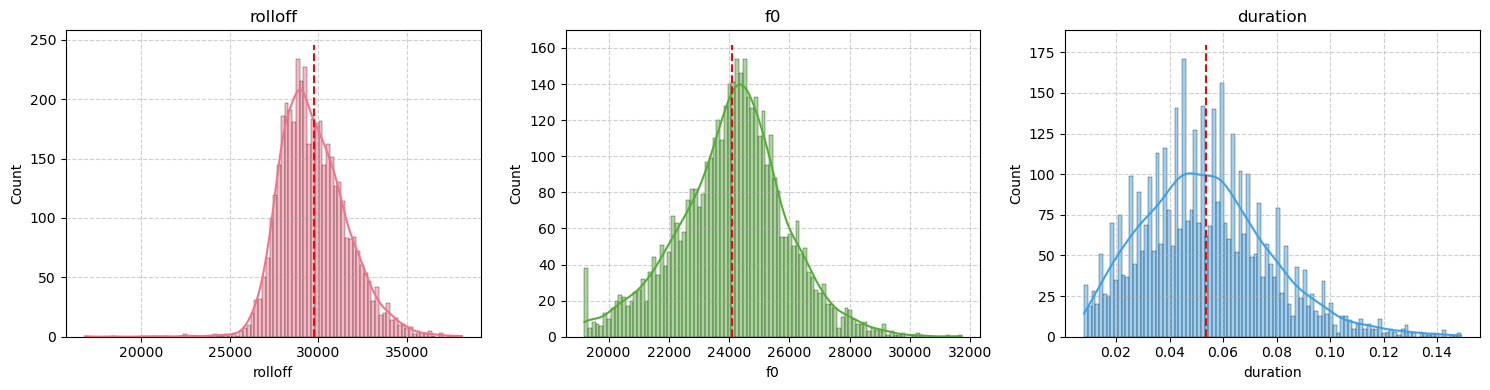

In [26]:
# Plots distributions of all USV features with mean lines

cols = ['rolloff', 'f0', 'duration']

# Create a long color palette
palette = sns.color_palette("husl", len(cols))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(
        data=usv_dataframe,
        x=col,
        bins=100,
        kde=True,
        ax=axes[i],
        color=palette[i]      # unique color per plot
    )
    
    # Add mean line
    mean_value = np.mean(usv_dataframe[col])
    ymin, ymax = axes[i].get_ylim()
    axes[i].vlines(mean_value, ymin, ymax, color='red', linestyle='--')
    
    # Add grid
    axes[i].grid(True, linestyle='--', alpha=0.6)
    
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

<Axes: xlabel='prox_to_trial_start', ylabel='Count'>

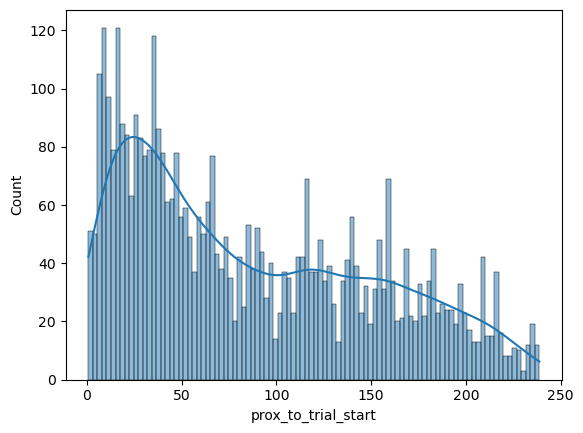

In [27]:
# Histogram of prox_to_trial_start

sns.histplot(data=usv_dataframe, x='prox_to_trial_start', bins=100, kde=True)

<Axes: xlabel='prox_to_lever_press', ylabel='Count'>

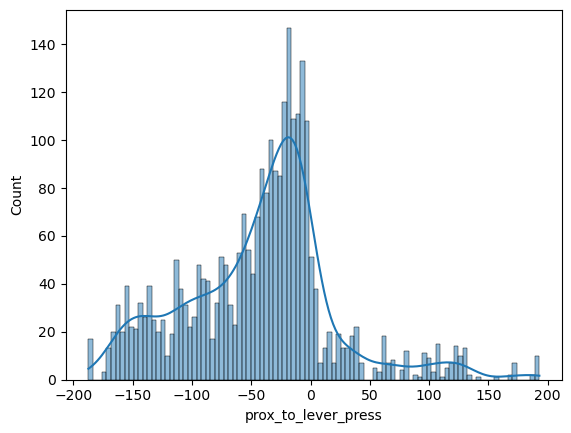

In [ ]:
# Histogram of prox_to_lever_press

sns.histplot(data=usv_dataframe, x='prox_to_lever_press', bins=100, kde=True)

<Axes: xlabel='relative_density', ylabel='open_latency'>

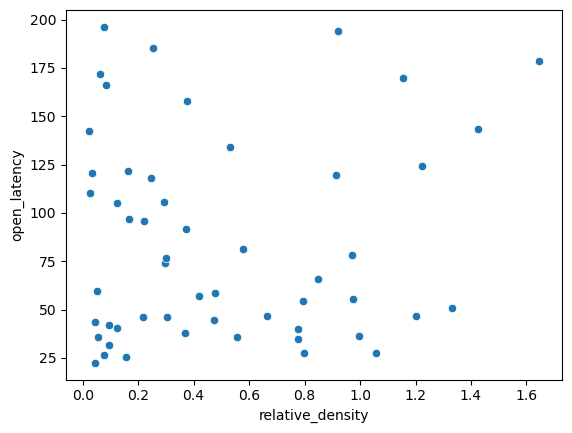

In [ ]:
# Scatterplot of relative_density vs open_latency for calls before lever press

sns.scatterplot(call_density[call_density['before_open'] == 'True'], x='relative_density', y='open_latency')

<Axes: xlabel='relative_density', ylabel='Count'>

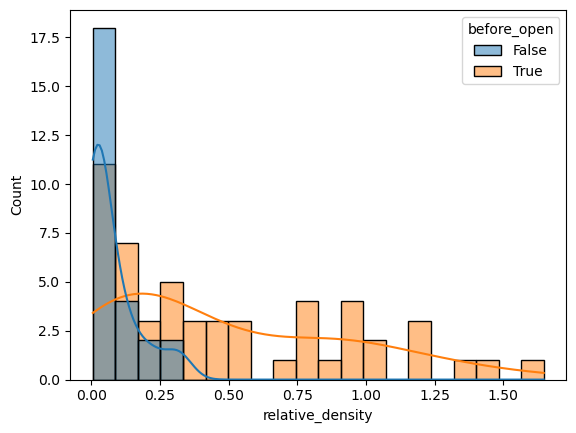

In [ ]:
# Gets histogram of call densities based on before_open status

sns.histplot(call_density, x='relative_density', kde=True, hue='before_open', bins=20)

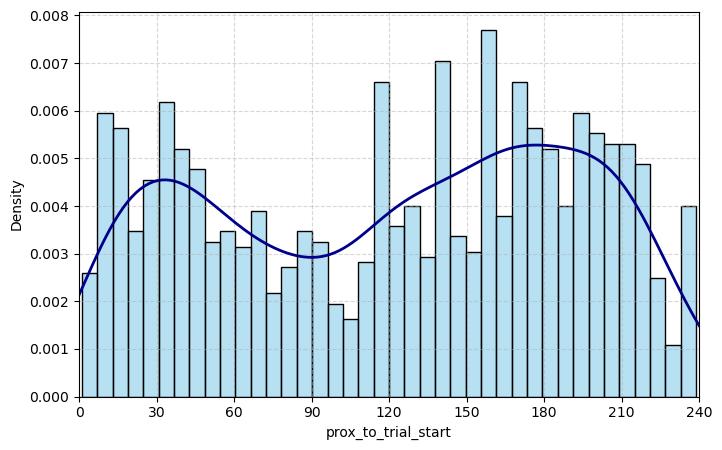

In [44]:
# Histogram of prox_to_trial_start for calls in trials with no lever_press

data = usv_dataframe[usv_dataframe['before_open'] == 'No Open']['prox_to_trial_start']

plt.figure(figsize=(8, 5))

# Histogram
sns.histplot(
    data,
    bins=40,
    stat='density',      # so histogram + kde align
    color='skyblue',     # histogram color
    alpha=0.6
)

# KDE
sns.kdeplot(
    data,
    color='darkblue',    # KDE color
    linewidth=2
)

plt.xlim(0, 240)
plt.xticks(np.arange(0, 241, 30))
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

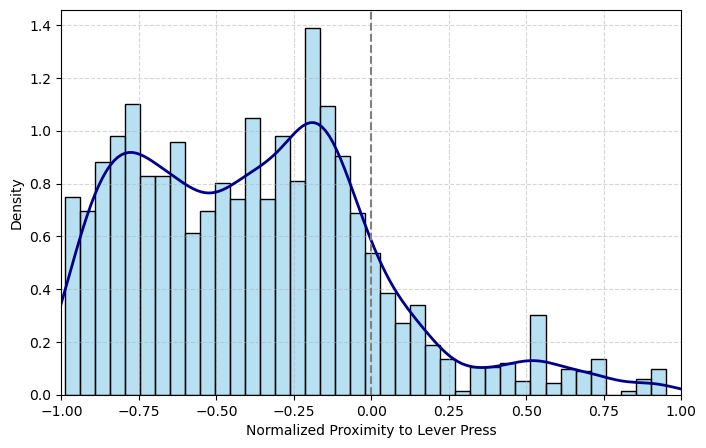

In [43]:
# Filter rows that have any kind of open
norm_open_df = usv_dataframe[usv_dataframe['before_open'] != 'No Open']

# Compute normalized values
norm_open = [
    (row['prox_to_lever_press'] / row['open_latency'])
    if row['before_open'] == 'True'
    else (row['prox_to_lever_press'] / (240 - row['open_latency']))
    for _, row in norm_open_df.iterrows()
]

plt.figure(figsize=(8, 5))

# Histogram
sns.histplot(
    norm_open,
    bins=40,
    stat='density',
    color='skyblue',       # histogram color
    alpha=0.6
)

# KDE
sns.kdeplot(
    norm_open,
    color='darkblue',      # KDE color
    linewidth=2
)
plt.axvline(0, color='gray', linestyle='--', linewidth=1.5)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(-1, 1)
plt.xticks(np.arange(-1, 1.01, 0.25))
plt.xlabel("Normalized Proximity to Lever Press")
plt.ylabel("Density")

plt.show()

### Plot rolling density with lever_press


/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_10613/3135786081.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_25kHz['before_open'] = df_25kHz['before_open'].fillna('No Open').astype(str)
/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_10613/3135786081.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_25kHz['before_open'] = df_25kHz['before_open'].fillna('No Open').astype(str)
/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_10613/3135786081.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ff

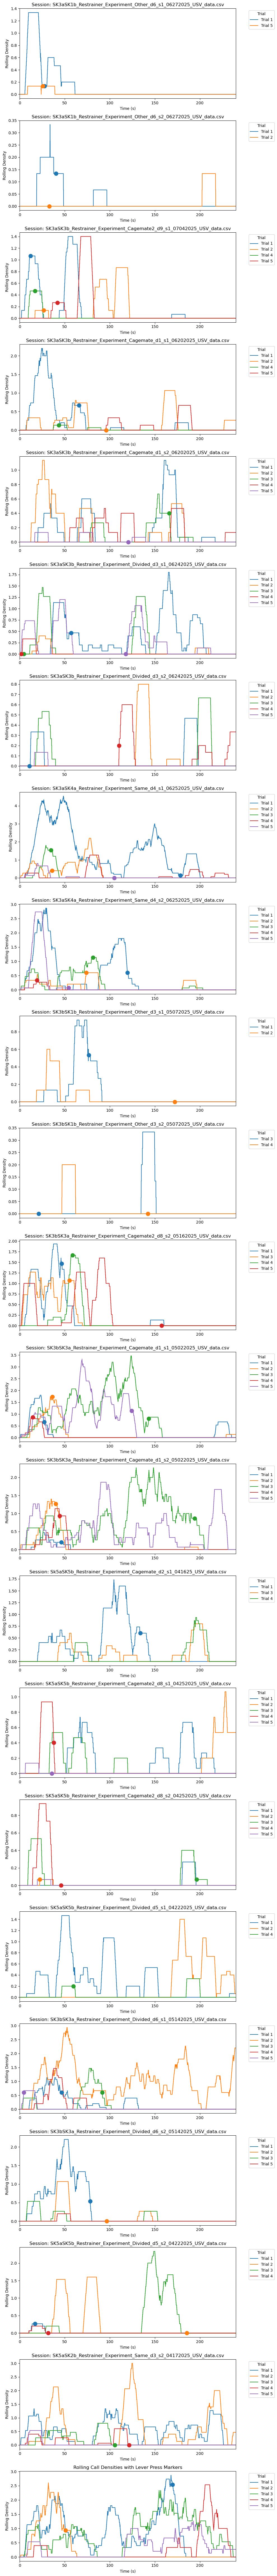

In [ ]:
# Plot rolling densities with lever press markers for each session, not normalized

# Define layout
n_sessions = len(usv_dataframes)
fig, axes = plt.subplots(n_sessions, 1, figsize=(10, 4 * n_sessions))

# If there's only one session, axes won't be an array — fix that
if n_sessions == 1:
    axes = [axes]

# Loop through each session and its corresponding subplot
for ax, (session_name, df) in zip(axes, usv_dataframes.items()):
    # Compute rolling densities for this session
    session_dict = get_rolling_density(df, window_size=15, bin_size=0.01)

    # Plot each trial
    for trial_num, (open_latency, open_latency_range, rolling_density) in session_dict.items():
        
        # if open_latency == 0:
        #     continue

        # Plot the line and get the Line2D object
        line = sns.lineplot(
            x=rolling_density.index,
            y=rolling_density.values,
            ax=ax,
            label=f"Trial {trial_num}"
        )

        # Get the color of the last line plotted
        line_color = line.get_lines()[-1].get_color()

        # Find y-value for lever press
        if rolling_density.index.min() <= open_latency <= rolling_density.index.max():
            nearest_idx = rolling_density.index.get_indexer([open_latency], method='nearest')[0]
            open_latency_y = rolling_density.iloc[nearest_idx]

            # Use the same color as the line
            ax.scatter(open_latency, open_latency_y, color=line_color, s=100, zorder=3)

    # Style this subplot
    ax.set_title(f"Session: {session_name}")
    ax.set_ylabel("Rolling Density")
    ax.set_xlim(0, 240)
    ax.set_xlabel("Time (s)")
    ax.legend(title="Trial", bbox_to_anchor=(1.05, 1), loc='upper left')

# Shared x-label for all
axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_10613/3135786081.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_25kHz['before_open'] = df_25kHz['before_open'].fillna('No Open').astype(str)
/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_10613/3135786081.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_25kHz['before_open'] = df_25kHz['before_open'].fillna('No Open').astype(str)
/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_10613/3135786081.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ff

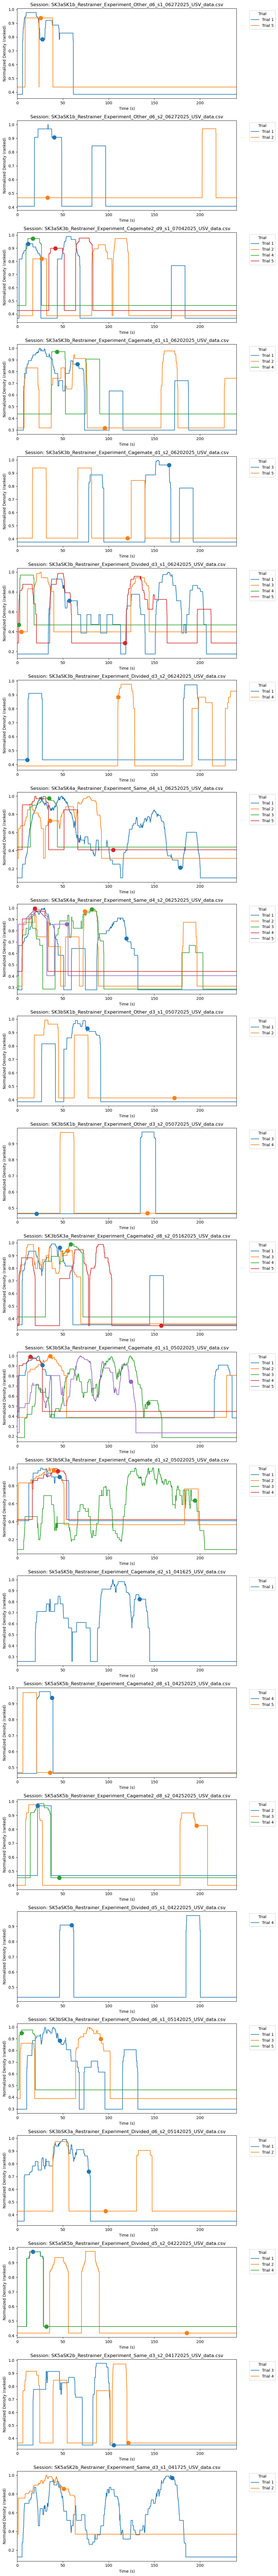

In [52]:
# Plot rolling densities with lever press markers for each session, with choice of normalization

# Choose normalization method: 'zscore', 'minmax', or None
norm_method = 'ranked'

# Define layout
n_sessions = len(usv_dataframes)
fig, axes = plt.subplots(n_sessions, 1, figsize=(10, 4 * n_sessions))

if n_sessions == 1:
    axes = [axes]

# Loop through sessions
for ax, (session_name, df) in zip(axes, usv_dataframes.items()):
    session_dict = get_rolling_density(df, window_size=15, bin_size=0.01)

    for trial_num, (open_latency, open_latency_range, rolling_density) in session_dict.items():
        if open_latency == 0:
            continue

        # Normalize per trial
        if norm_method == 'zscore':
            norm_density = pd.Series(
                stats.zscore(rolling_density.values, nan_policy='omit'),
                index=rolling_density.index
            )
        elif norm_method == 'minmax':
            norm_density = (rolling_density - rolling_density.min()) / (rolling_density.max() - rolling_density.min())
        elif norm_method == 'ranked':
            norm_density = rankdata(rolling_density.values, method='average') / (len(rolling_density.values) + 1)
            norm_density = pd.Series(norm_density, index=rolling_density.index)
        else:
            norm_density = rolling_density  # raw density

        # Plot the line
        line = sns.lineplot(
            x=norm_density.index,
            y=norm_density.values,
            ax=ax,
            label=f"Trial {trial_num}"
        )

        # Get line color
        line_color = line.get_lines()[-1].get_color()

        # Plot open latency as a dot in same color
        if rolling_density.index.min() <= open_latency <= rolling_density.index.max():
            nearest_idx = rolling_density.index.get_indexer([open_latency], method='nearest')[0]
            open_latency_y = norm_density.iloc[nearest_idx]
            ax.scatter(open_latency, open_latency_y, color=line_color, s=100, zorder=3)

    # Style subplot
    ax.set_title(f"Session: {session_name}")
    ax.set_ylabel(f"Normalized Density ({norm_method})" if norm_method else "Density")
    ax.set_xlim(0, 240)
    ax.set_xlabel("Time (s)")
    ax.legend(title="Trial", bbox_to_anchor=(1.05, 1), loc='upper left')

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()


/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_11697/3285196047.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


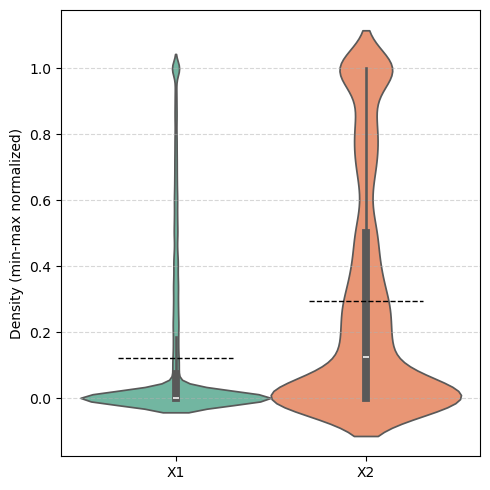

In [19]:
# Violin plot of min-max normalized densities by open_bin status

plt.figure(figsize=(5, 5))

# Custom colors for violins
palette = ['#66c2a5', '#fc8d62']  # blue and orange

ax = sns.violinplot(
    data=rolling_density_df,
    y='density_minmax',
    x='open_bin',
    palette=palette,
    inner='box',   # show median + quartiles
    width=1            # wider violins (default ~0.5)
)

# Compute means for each category
means = rolling_density_df.groupby('open_bin')['density_minmax'].mean().values

# Overlay mean as a horizontal line inside each violin
for i, mean_val in enumerate(means):
    ax.hlines(mean_val, i - 0.3, i + 0.3, color='black', linestyle='--', linewidth=1
            )

# Relabel x-ticks
plt.xticks([0, 1], ['X1', 'X2'])

# Add grid along y-axis
plt.grid(True, linestyle='--', alpha=0.5, axis='y')

plt.xlabel('')
plt.ylabel('Density (min-max normalized)')

plt.tight_layout()
plt.show()

/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_13907/3985835360.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_13907/3985835360.py:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_13907/3985835360.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Excluding", "Including"], rotation=30, fontsize=12)


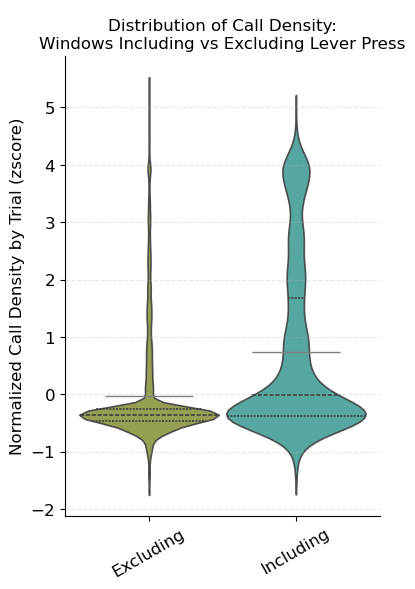

In [75]:
palette = sns.color_palette("husl", 8)
fig, ax = plt.subplots(figsize=(4, 6))  # More aesthetic size

sns.violinplot(
    data=rolling_density_df,
    y='density_zscore',
    x='open_bin',
    palette=[palette[2], palette[4]],   # Nice contrasting colors
    inner='quartile',                 # Show quartiles inside violins
    linewidth=1.2,
    width=0.95,
    scale='width',
    alpha=0.9,
    ax=ax
)

means = rolling_density_df.groupby('open_bin')['density_zscore'].mean().values
for i, mean_val in enumerate(means):
    ax.hlines(mean_val, i - 0.3, i + 0.3, color='gray', linestyle='-', linewidth=1
            )

# Axis labels and title
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('Normalized Call Density by Trial (zscore)', fontsize=12)
ax.set_title('Distribution of Call Density:\nWindows Including vs Excluding Lever Press',
             fontsize=12)

# Fix x-tick labels (replace "Label A/B" with whatever you want)
ax.set_xticklabels(["Excluding", "Including"], rotation=30, fontsize=12)

# Legend (placed above)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    ['Excluding lever_press', 'Including lever_press'],
    loc='upper center',
    bbox_to_anchor=(0.5, 1.12),
    ncol=2,
    frameon=False,
    fontsize=12,
    title_fontsize=12
)

# Tick styling
ax.tick_params(axis='both', labelsize=12)

# Grid + despine
ax.grid(axis='y', linestyle='--', alpha=0.3)
sns.despine()

plt.tight_layout()
plt.show()






In [51]:
rolling_density_df 

filename  trial_num    time  \
0       SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...          1    0.05   
1       SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...          1    0.15   
2       SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...          1    0.25   
3       SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...          1    0.35   
4       SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...          1    0.45   
...                                                   ...        ...     ...   
225595  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...          5  239.55   
225596  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...          5  239.65   
225597  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...          5  239.75   
225598  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...          5  239.85   
225599  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...          5  239.95   

         density  open_bin time_vs_open  open_latency  \
0       0.000000     False       Before       27.5338   
1       0.000000     False       Before       27.5338   
2       0.000000     False       Before       27.5338   
3       0.000000     False       Before       27.5338   
4       0.000000     False       Before       27.5338   
...          ...       ...          ...           ...   
225595  0.266667     False      No Open        0.0000   
225596  0.266667     False      No Open        0.0000   
225597  0.266667     False      No Open        0.0000   
225598  0.266667     False      No Open        0.0000   
225599  0.266667     False      No Open        0.0000   

                                open_latency_range  density_minmax  \
0       (np.float64(27.5338), np.float64(42.5338))        0.000000   
1       (np.float64(27.5338), np.float64(42.5338))        0.000000   
2       (np.float64(27.5338), np.float64(42.5338))        0.000000   
3       (np.float64(27.5338), np.float64(42.5338))        0.000000   
4       (np.float64(27.5338), np.float64(42.5338))        0.000000   
...                                            ...             ...   
225595                                      (0, 0)        0.210526   
225596                                      (0, 0)        0.210526   
225597                                      (0, 0)        0.210526   
225598                                      (0, 0)        0.210526   
225599                                      (0, 0)        0.210526   

        density_zscore  density_ranked  
0            -0.412693        0.384215  
1            -0.412693        0.384215  
2            -0.412693        0.384215  
3            -0.412693        0.384215  
4            -0.412693        0.384215  
...                ...             ...  
225595       -0.198860        0.535402  
225596       -0.198860        0.535402  
225597       -0.198860        0.535402  
225598       -0.198860        0.535402  
225599       -0.198860        0.535402  

[225600 rows x 11 columns]

In [76]:
temp = rolling_density_df[(rolling_density_df['time_vs_open'] != 'After') & (rolling_density_df['time_vs_open'] != 'No Open')]
temp

filename  trial_num   time  \
0       SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...          1   0.05   
1       SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...          1   0.15   
2       SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...          1   0.25   
3       SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...          1   0.35   
4       SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...          1   0.45   
...                                                   ...        ...    ...   
216655  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...          2  65.55   
216656  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...          2  65.65   
216657  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...          2  65.75   
216658  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...          2  65.85   
216659  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...          2  65.95   

        density  open_bin time_vs_open  open_latency  \
0           0.0     False       Before       27.5338   
1           0.0     False       Before       27.5338   
2           0.0     False       Before       27.5338   
3           0.0     False       Before       27.5338   
4           0.0     False       Before       27.5338   
...         ...       ...          ...           ...   
216655      0.0      True       During       50.9990   
216656      0.0      True       During       50.9990   
216657      0.0      True       During       50.9990   
216658      0.0      True       During       50.9990   
216659      0.0      True       During       50.9990   

                                       open_latency_range  density_minmax  \
0              (np.float64(27.5338), np.float64(42.5338))             0.0   
1              (np.float64(27.5338), np.float64(42.5338))             0.0   
2              (np.float64(27.5338), np.float64(42.5338))             0.0   
3              (np.float64(27.5338), np.float64(42.5338))             0.0   
4              (np.float64(27.5338), np.float64(42.5338))             0.0   
...                                                   ...             ...   
216655  (np.float64(50.99900000000002), np.float64(65....             0.0   
216656  (np.float64(50.99900000000002), np.float64(65....             0.0   
216657  (np.float64(50.99900000000002), np.float64(65....             0.0   
216658  (np.float64(50.99900000000002), np.float64(65....             0.0   
216659  (np.float64(50.99900000000002), np.float64(65....             0.0   

        density_zscore  density_ranked  
0            -0.412693        0.384215  
1            -0.412693        0.384215  
2            -0.412693        0.384215  
3            -0.412693        0.384215  
4            -0.412693        0.384215  
...                ...             ...  
216655       -0.464068        0.370054  
216656       -0.464068        0.370054  
216657       -0.464068        0.370054  
216658       -0.464068        0.370054  
216659       -0.464068        0.370054  

[56139 rows x 11 columns]

/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_13907/3325417897.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_13907/3325417897.py:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_13907/3325417897.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Excluding", "Including"], rotation=30, fontsize=12)


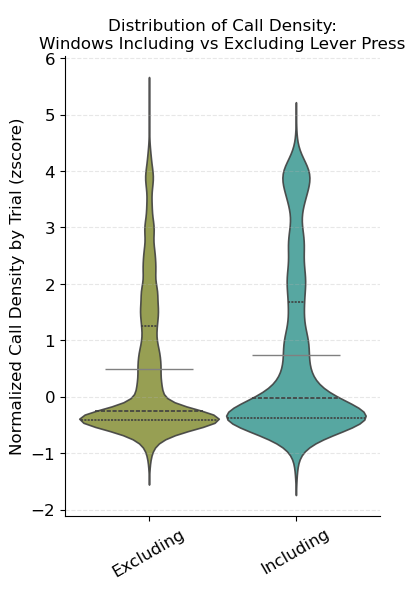

In [77]:
palette = sns.color_palette("husl", 8)
fig, ax = plt.subplots(figsize=(4, 6))  # More aesthetic size

sns.violinplot(
    data=temp,
    y='density_zscore',
    x='open_bin',
    palette=[palette[2], palette[4]],   # Nice contrasting colors
    inner='quartile',                 # Show quartiles inside violins
    linewidth=1.2,
    width=0.95,
    scale='width',
    alpha=0.9,
    ax=ax
)

means = temp.groupby('open_bin')['density_zscore'].mean().values
for i, mean_val in enumerate(means):
    ax.hlines(mean_val, i - 0.3, i + 0.3, color='gray', linestyle='-', linewidth=1
            )

# Axis labels and title
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('Normalized Call Density by Trial (zscore)', fontsize=12)
ax.set_title('Distribution of Call Density:\nWindows Including vs Excluding Lever Press',
             fontsize=12)

# Fix x-tick labels (replace "Label A/B" with whatever you want)
ax.set_xticklabels(["Excluding", "Including"], rotation=30, fontsize=12)

# Legend (placed above)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    ['Excluding lever_press', 'Including lever_press'],
    loc='upper center',
    bbox_to_anchor=(0.5, 1.12),
    ncol=2,
    frameon=False,
    fontsize=12,
    title_fontsize=12
)

# Tick styling
ax.tick_params(axis='both', labelsize=12)

# Grid + despine
ax.grid(axis='y', linestyle='--', alpha=0.3)
sns.despine()

plt.tight_layout()
plt.show()

In [30]:
sns.color_palette("husl", 8)[0]

(0.9677975592919913, 0.44127456009157356, 0.5358103155058701)

In [1]:
# log scaled histogram of min-max normalized densities by open_bin status
plt.figure(figsize=(8, 5))
sns.displot(data=rolling_density_df, x='density_minmax', hue='open_bin', bins=50, log_scale=True)

NameError: name 'plt' is not defined

In [92]:
def seaborn_ecdf_zero_handling(data, label):
    data = np.array(data)

    # proportion of zero values
    p0 = np.mean(data == 0)

    # plot the zero mass
    plt.scatter([0], [p0], s=60, label=f"{label} zero mass")

    # ECDF for values > 0
    nz = data[data > 0]
    sns.ecdfplot(nz, label=f"{label} (>0 part)")

In [36]:
true_data = rolling_density_df[rolling_density_df['open_bin'] == True]['density_minmax'].values
false_data = rolling_density_df[rolling_density_df['open_bin'] == False]['density_minmax'].values


/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_4217/3109186298.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/sophieneale/miniforge3/envs/usvprocessing/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


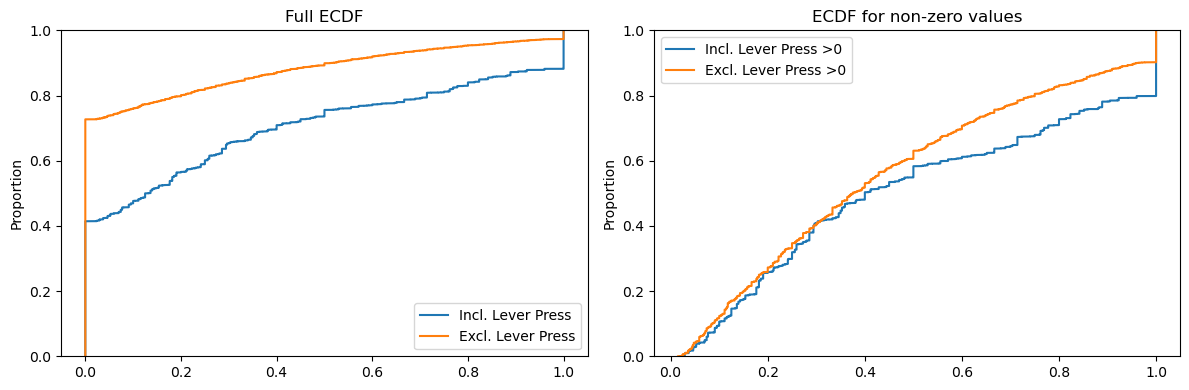

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# Full ECDF
sns.ecdfplot(data=true_data, ax=ax1, label="Incl. Lever Press")
sns.ecdfplot(data=false_data, ax=ax1, label="Excl. Lever Press")
ax1.set_title("Full ECDF")
ax1.legend()

# Zoomed: only non-zero values
sns.ecdfplot(data=true_data[true_data>0], ax=ax2, label="Incl. Lever Press >0")
sns.ecdfplot(data=false_data[false_data>0], ax=ax2, label="Excl. Lever Press >0")
ax2.set_title("ECDF for non-zero values")
ax2.legend()

plt.tight_layout()
plt.show()

In [31]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

def plot_additional_ecdf_after_zero(data, label, color='C0', linestyle='-', linewidth=2, alpha=1):
    data = np.array(data)
    p0 = np.mean(data == 0)
    plt.scatter([0], [p0], s=80, color=color, edgecolor='black', zorder=10, alpha=alpha, label=f"{label} zero mass")
    
    nz = data[data > 0]
    x_nz, y_nz = ecdf(nz)
    y_adj = (1 - p0) * y_nz
    plt.step(x_nz, y_adj, where="post", color=color, linestyle=linestyle, linewidth=linewidth, alpha=alpha,
             label=f"{label} (additional mass)")

In [34]:
true_data = rolling_density_df[rolling_density_df['open_bin'] == True]['density_minmax'].values
false_data = rolling_density_df[rolling_density_df['open_bin'] == False]['density_minmax'].values


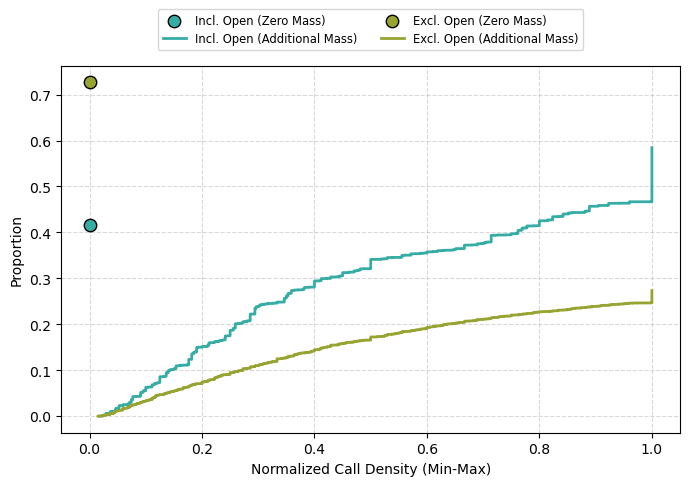

In [35]:
plt.figure(figsize=(7,5))
plot_additional_ecdf_after_zero(true_data, "Incl. Lever Press", color=palette[4])
plot_additional_ecdf_after_zero(false_data, "Excl. Lever Press", color=palette[2])
plt.xlabel("Normalized Call Density (Min-Max)")
plt.ylabel("Proportion")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles,
    ['Incl. Open (Zero Mass)', 'Incl. Open (Additional Mass)', 'Excl. Open (Zero Mass)', 'Excl. Open (Additional Mass)'],
    loc='upper center', fontsize='small', ncol=2,
        bbox_to_anchor=(0.5, 1.17)
)
plt.grid(True, linestyle='--', alpha=0.3, color='gray', fillstyle='full')
plt.tight_layout()
plt.show()

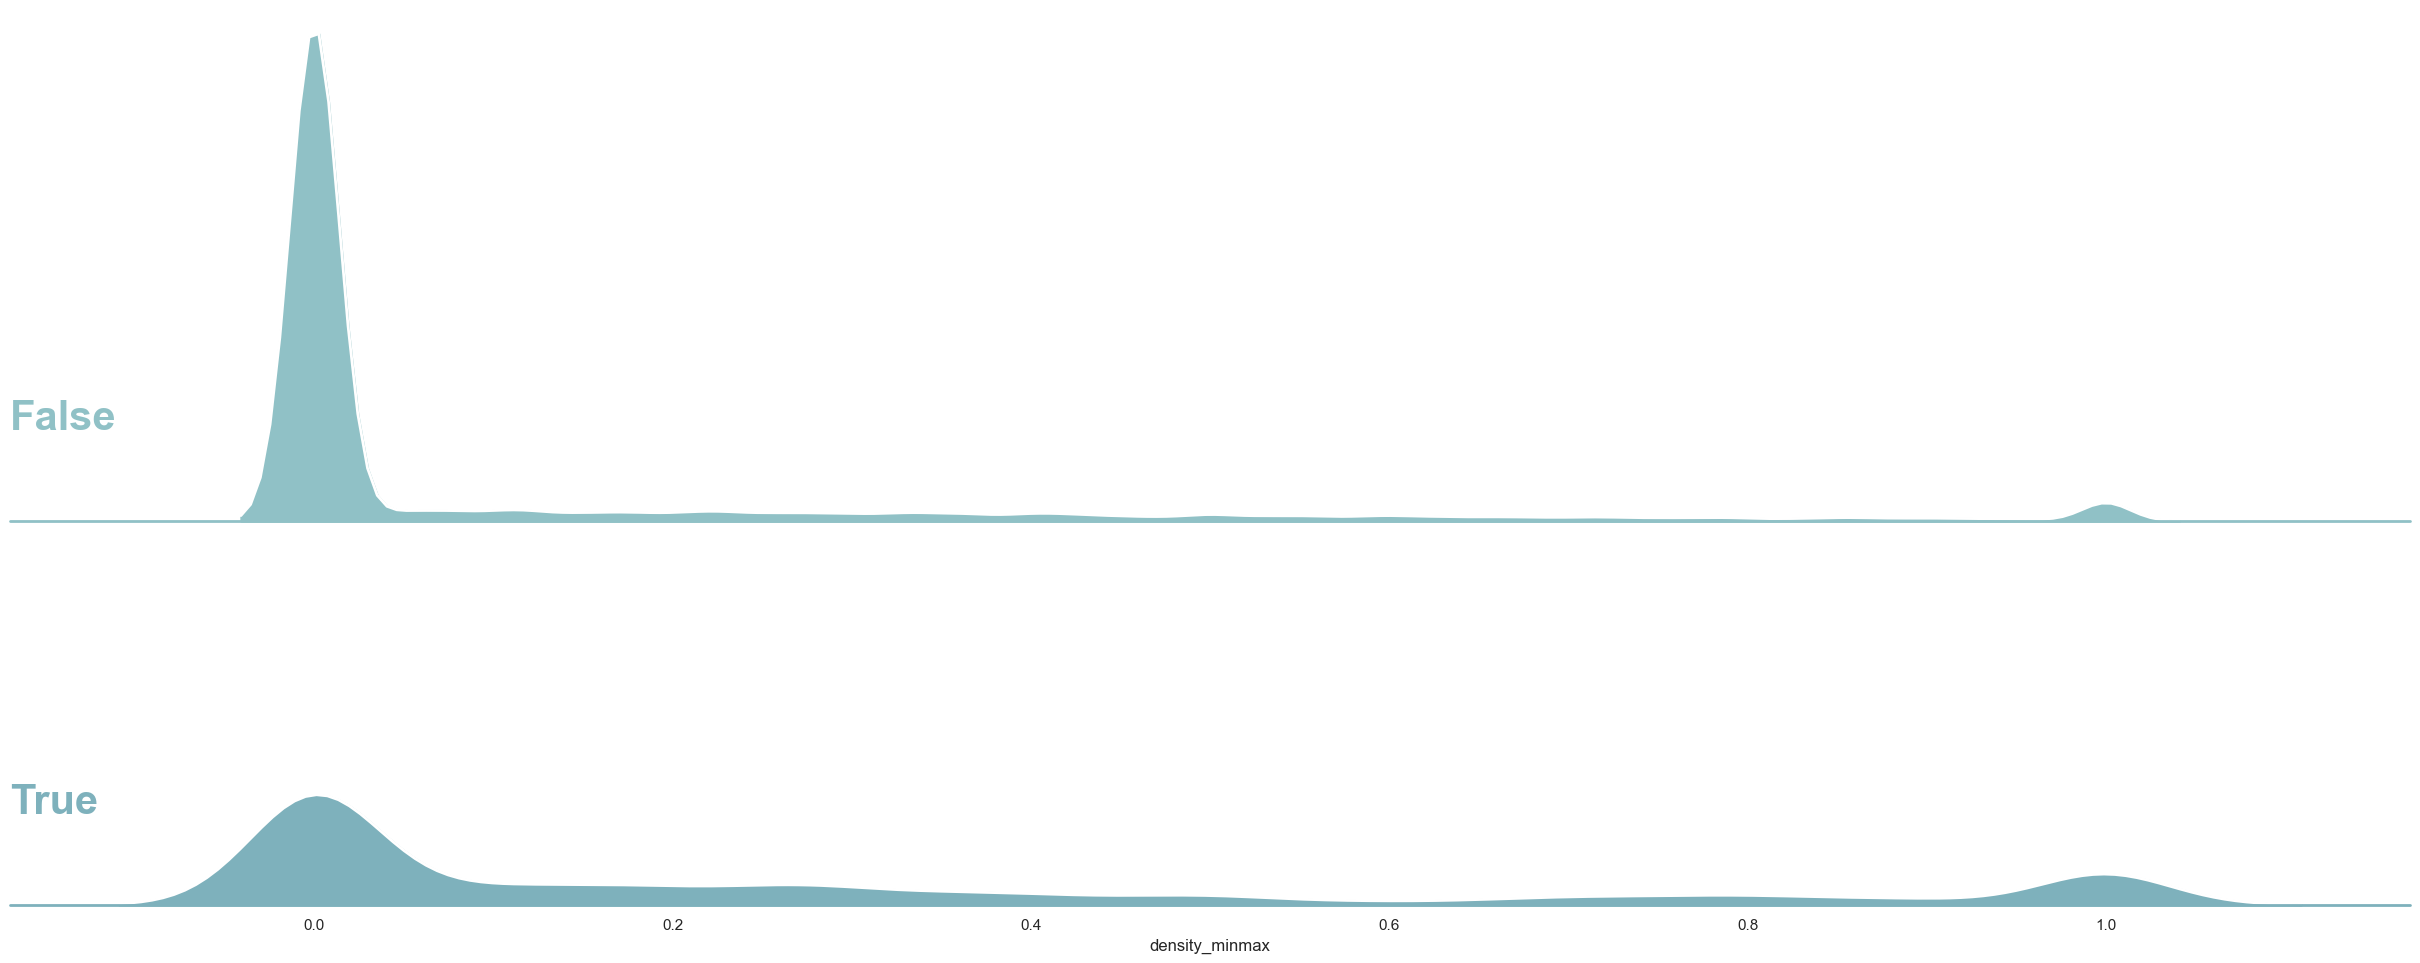

In [124]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(rolling_density_df, row="open_bin", hue="open_bin", aspect=5, height=5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "density_minmax",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "density_minmax", clip_on=False, color="w", lw=2, bw_adjust=1)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes,
            fontsize= 30)


g.map(label, "density_minmax")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Make figure less wide
# g.figure.set_size_inches(10, 16)  # width, height

# # Global title
# g.figure.suptitle("Open-Bin Rolling Density Distributions", fontsize=36, y=1.03)

# # Global y-axis label
# g.figure.text(0.02, 0.5, "Open Bin", va="center", rotation="vertical", fontsize=28)

# # X-axis label
# g.set_xlabels("Density (scaled)", fontsize=28)

# # Increase x tick label size
# for ax in g.axes.flat:
#     ax.tick_params(axis='x', labelsize=22, width=2)

<Axes: xlabel='open_bin', ylabel='density_zscore'>

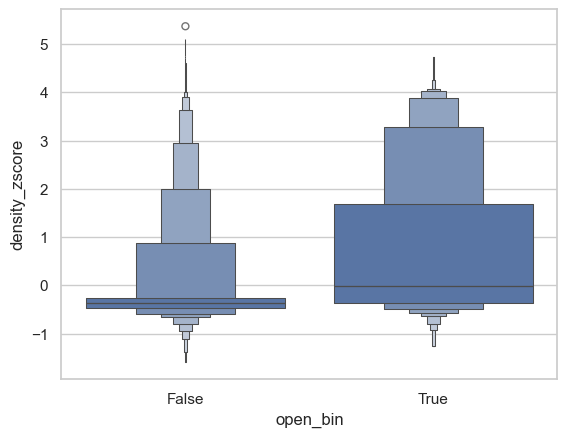

In [148]:
sns.set_theme(style="whitegrid")

sns.boxenplot(
    rolling_density_df, x="open_bin", y="density_zscore",
    color="b", width_method="exponential", k_depth=15, trust_alpha = 0.01, orient='v'
)

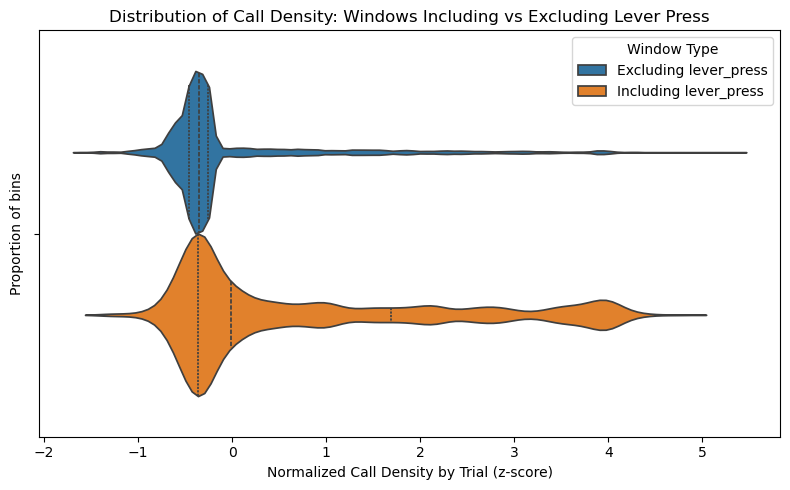

In [74]:
# Violin plot of z-score normalized densities by open_bin status

plt.figure(figsize=(8, 5))
sns.violinplot(data=rolling_density_df, x='density_zscore', hue='open_bin', inner='quartile')

plt.xlabel(f'Normalized Call Density by Trial (z-score)')
plt.ylabel('Proportion of bins')
plt.title('Distribution of Call Density: Windows Including vs Excluding Lever Press')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles,
    ['Excluding lever_press', 'Including lever_press'],
    title='Window Type',
    loc='upper right'
)
plt.tight_layout()
plt.show()

In [155]:
temp = rolling_density_df.merge(session_info_dataframe, on=['filename', 'trial_num'], how='left')

In [157]:
session_info_dataframe

trial_num  trial_start  lever_press  open_latency calls_before  \
0          1.0      72.4872     100.0210       27.5338         True   
1          2.0     467.0620       0.0000           NaN        False   
2          3.0     832.3360       0.0000           NaN        False   
3          4.0    1186.9790    1195.3590        8.3800        False   
4          5.0    1550.9490    1576.5490       25.6000         True   
..         ...          ...          ...           ...          ...   
111        1.0      99.5453     269.1443      169.5990         True   
112        2.0     465.3423     516.3413       50.9990         True   
113        3.0     816.1383       0.0000           NaN        False   
114        4.0    1191.7633       0.0000           NaN        False   
115        5.0    1548.1333       0.0000           NaN        False   

    calls_after                                           filename free_rat  \
0          True  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...     sk3a   
1         False  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...     sk3a   
2         False  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...     sk3a   
3         False  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...     sk3a   
4         False  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...     sk3a   
..          ...                                                ...      ...   
111       False  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...     sk5a   
112       False  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...     sk5a   
113       False  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...     sk5a   
114       False  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...     sk5a   
115       False  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...     sk5a   

    restrainer_rat condition  
0             sk1b     Other  
1             sk1b     Other  
2             sk1b     Other  
3             sk1b     Other  
4             sk1b     Other  
..             ...       ...  
111           sk2b      Same  
112           sk2b      Same  
113           sk2b      Same  
114           sk2b      Same  
115           sk2b      Same  

[116 rows x 10 columns]

In [ ]:
sns.violinplot(data=rolling_density_df, x="class", y="age", hue="alive", split=True, gap=.1, inner="quart")

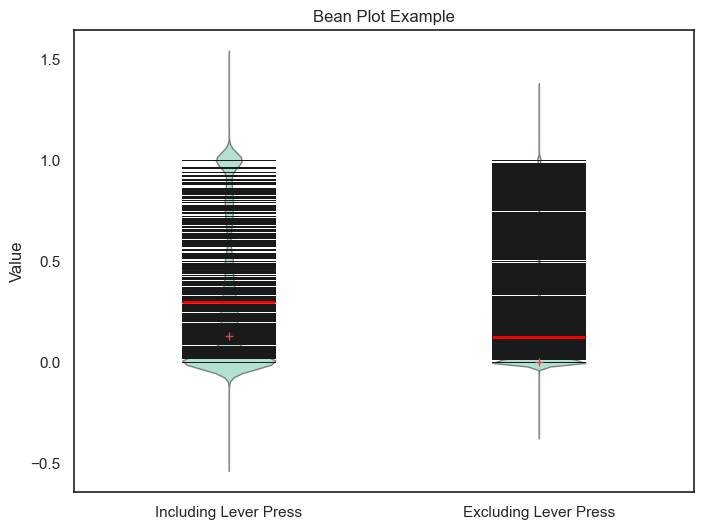

In [122]:
datasequence = [true_data, false_data]

fig, ax = plt.subplots(figsize=(8, 6))
beanplot(datasequence, ax=ax, labels=labels,
         plot_opts={'bean_colors': ['skyblue', 'lightgreen'],
                    'bean_show_mean': True,
                    'bean_mean_color': 'red',
                    'jitter': True,
                    'jitter_marker_size': 4})

ax.set_title('Bean Plot Example')
ax.set_ylabel('Value')
plt.show()

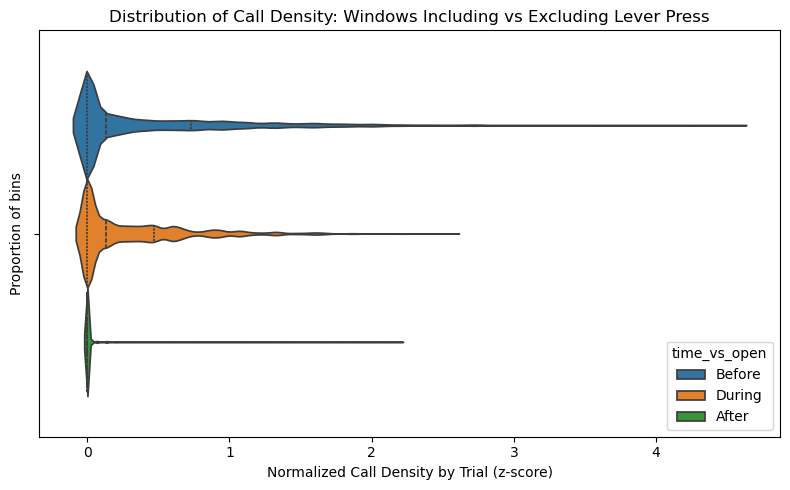

In [ ]:
# Violin plot of z-score normalized densities by open_bin status

plt.figure(figsize=(8, 5))
sns.violinplot(data=rolling_density_df, x='density', hue='time_vs_open', inner='quartile')

plt.xlabel(f'Normalized Call Density by Trial (z-score)')
plt.ylabel('Proportion of bins')
plt.title('Distribution of Call Density: Windows Including vs Excluding Lever Press')

# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(
#     handles,
#     ['Excluding lever_press', 'Including lever_press'],
#     title='Window Type',
#     loc='upper right'
# )
plt.tight_layout()
plt.show()

In [ ]:
# temp = rolling_density_df.groupby(by=['time_vs_open']).mean()[['density_zscore', 'density_minmax', 'density']]

## Statistical analyses

<Axes: ylabel='rank_biserial_corr'>

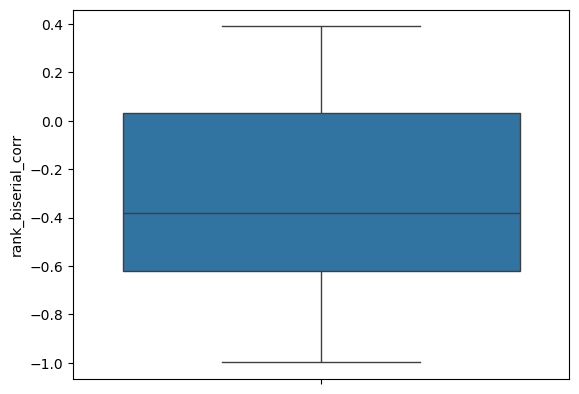

In [ ]:
sns.boxplot(stats_df['rank_biserial_corr'])

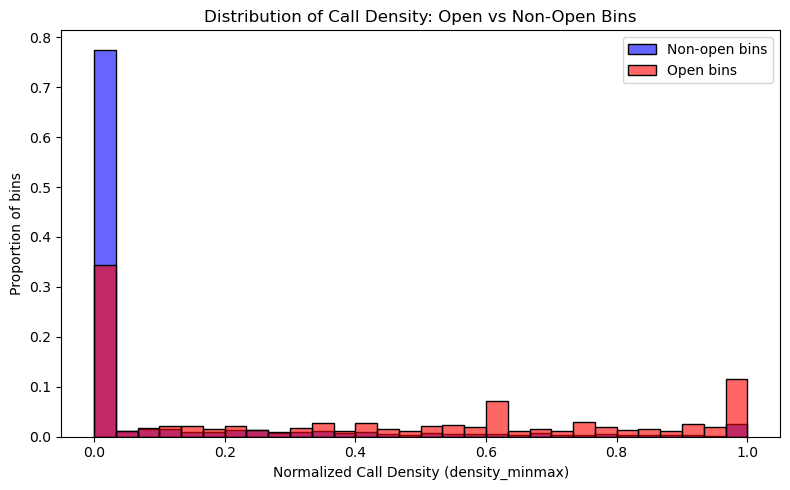

In [ ]:
density_col = 'density_minmax'  # or 'density_minmax'

# Prepare figure
plt.figure(figsize=(8, 5))

# Plot histogram for non-open bins
sns.histplot(
    rolling_density_df.loc[~rolling_density_df.open_bin, density_col],
    bins=30,
    stat='probability',  # y-axis = proportion of bins
    color='blue',
    label='Non-open bins',
    alpha=0.6
)

# Plot histogram for open bins
sns.histplot(
    rolling_density_df.loc[rolling_density_df.open_bin, density_col],
    bins=30,
    stat='probability',
    color='red',
    label='Open bins',
    alpha=0.6
)

plt.xlabel(f'Normalized Call Density ({density_col})')
plt.ylabel('Proportion of bins')
plt.title('Distribution of Call Density: Open vs Non-Open Bins')
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_2392/3774057552.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_25kHz['before_open'] = df_25kHz['before_open'].fillna('No Open').astype(str)
/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_2392/3774057552.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_25kHz['before_open'] = df_25kHz['before_open'].fillna('No Open').astype(str)
/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_2392/3774057552.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill

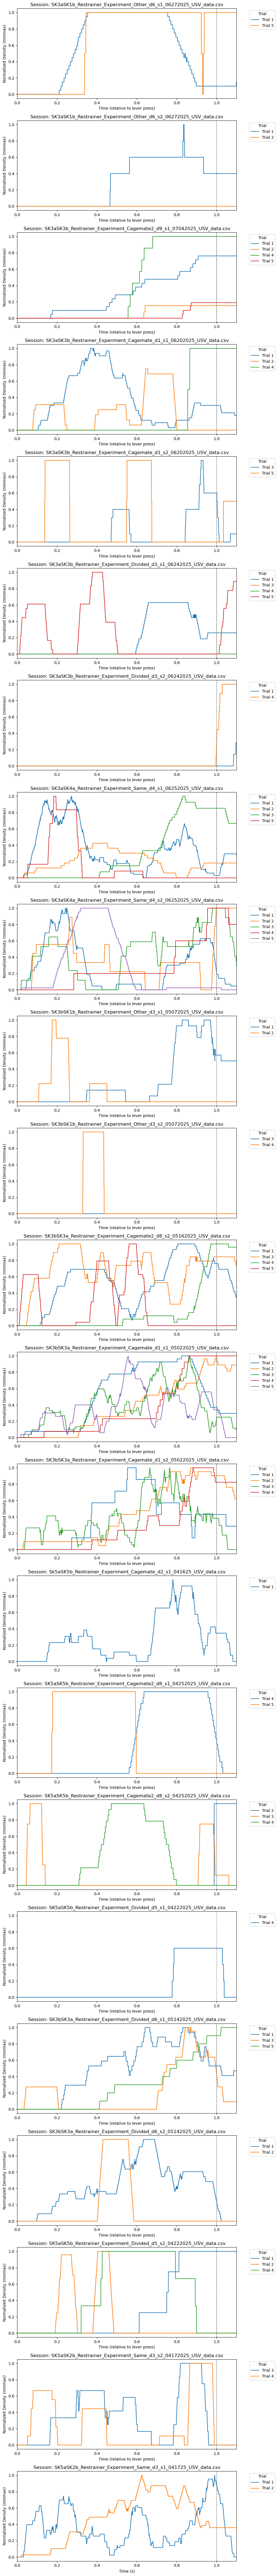

In [ ]:
# Choose normalization method: 'zscore', 'minmax', or None
norm_method = 'minmax'

# Define layout
n_sessions = len(usv_dataframes)
fig, axes = plt.subplots(n_sessions, 1, figsize=(10, 4 * n_sessions))

if n_sessions == 1:
    axes = [axes]

# Loop through sessions
for ax, (session_name, df) in zip(axes, usv_dataframes.items()):
    session_dict = get_rolling_density(df, window_size=15, bin_size=0.01)

    for trial_num, (open_latency, open_latency_range, rolling_density) in session_dict.items():
        if open_latency == 0:
            continue

        # Normalize per trial
        if norm_method == 'zscore':
            norm_density = pd.Series(
                stats.zscore(rolling_density.values, nan_policy='omit'),
                index=rolling_density.index
            )
        elif norm_method == 'minmax':
            norm_density = (rolling_density - rolling_density.min()) / (rolling_density.max() - rolling_density.min())
        else:
            norm_density = rolling_density  # raw density

        # before_open = norm_density[rolling_density.index < open_latency]
        norm_density.index = norm_density.index / open_latency

        # Plot the line
        line = sns.lineplot(
            x=norm_density.index,
            y=norm_density.values,
            ax=ax,
            label=f"Trial {trial_num}"
        )

        # Get line color
        line_color = line.get_lines()[-1].get_color()

        # Add line at x=1 for lever press
        ax.axvline(x=1, color='gray', linestyle='--', linewidth=1)

        # # Plot open latency as a dot in same color
        # if rolling_density.index.min() <= open_latency <= rolling_density.index.max():
        #     nearest_idx = rolling_density.index.get_indexer([open_latency], method='nearest')[0]
        #     open_latency_y = norm_density.iloc[nearest_idx]
        #     ax.scatter(open_latency, open_latency_y, color=line_color, s=100, zorder=3)

    # Style subplot
    ax.set_title(f"Session: {session_name}")
    ax.set_ylabel(f"Normalized Density ({norm_method})" if norm_method else "Density")
    ax.set_xlim(0, 1.1)
    ax.set_xlabel("Time (relative to lever press)")
    ax.legend(title="Trial", bbox_to_anchor=(1.05, 1), loc='upper left')

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

In [36]:
session_info_dataframe

trial_num  trial_start  lever_press  open_latency calls_before  \
0          1.0      72.4872     100.0210       27.5338         True   
1          2.0     467.0620       0.0000           NaN        False   
2          3.0     832.3360       0.0000           NaN        False   
3          4.0    1186.9790    1195.3590        8.3800        False   
4          5.0    1550.9490    1576.5490       25.6000         True   
..         ...          ...          ...           ...          ...   
111        1.0      99.5453     269.1443      169.5990         True   
112        2.0     465.3423     516.3413       50.9990         True   
113        3.0     816.1383       0.0000           NaN        False   
114        4.0    1191.7633       0.0000           NaN        False   
115        5.0    1548.1333       0.0000           NaN        False   

    calls_after                                           filename free_rat  \
0          True  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...     sk3a   
1         False  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...     sk3a   
2         False  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...     sk3a   
3         False  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...     sk3a   
4         False  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...     sk3a   
..          ...                                                ...      ...   
111       False  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...     sk5a   
112       False  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...     sk5a   
113       False  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...     sk5a   
114       False  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...     sk5a   
115       False  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...     sk5a   

    restrainer_rat condition  
0             sk1b     Other  
1             sk1b     Other  
2             sk1b     Other  
3             sk1b     Other  
4             sk1b     Other  
..             ...       ...  
111           sk2b      Same  
112           sk2b      Same  
113           sk2b      Same  
114           sk2b      Same  
115           sk2b      Same  

[116 rows x 10 columns]

<Axes: xlabel='condition', ylabel='count'>

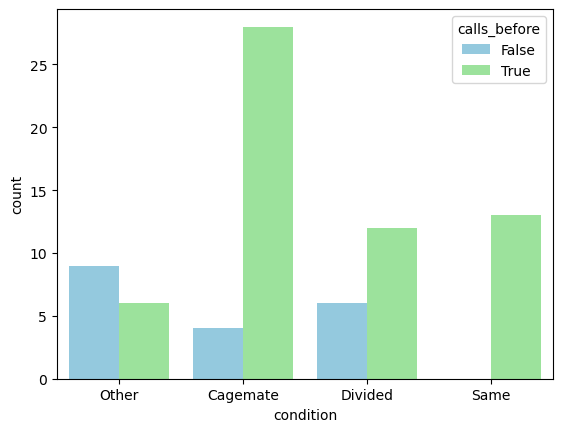

In [49]:
temp = session_info_dataframe[session_info_dataframe['open_tf'] == True]
sns.countplot(data=temp, x='condition', hue='calls_before', palette=['skyblue', 'lightgreen'])

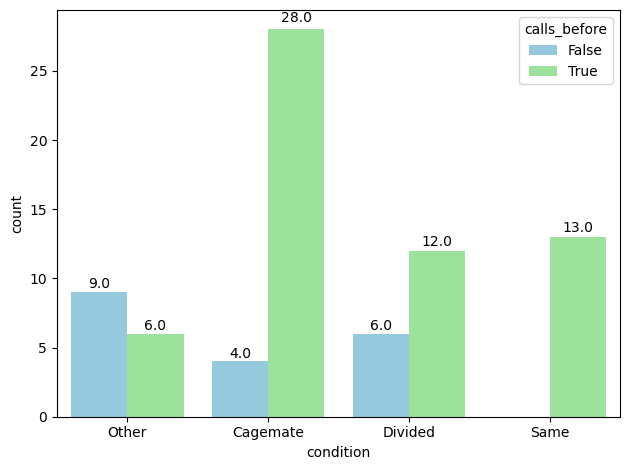

In [79]:
ax = sns.countplot(
    data=temp,
    x='condition',
    hue='calls_before',
    palette=['skyblue', 'lightgreen']
)

# Add counts above bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + 0.01 * height,   # slight offset
            str(height),
            ha='center',
            va='bottom',
            fontsize=10
        )

plt.tight_layout()
plt.show()


<Axes: xlabel='condition', ylabel='count'>

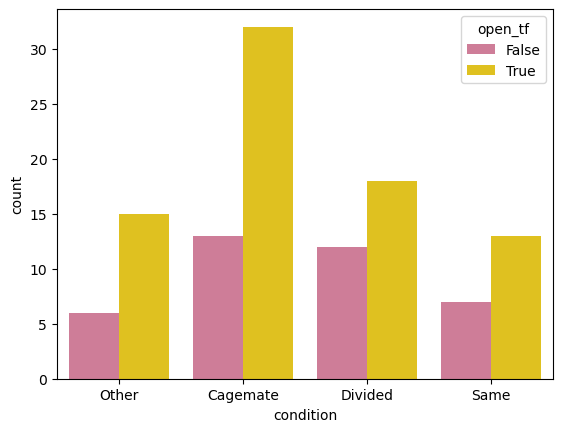

In [53]:
sns.countplot(data=session_info_dataframe, x='condition', hue='open_tf', palette=['palevioletred','gold'])

In [64]:
counts = (
    session_info_dataframe.groupby(['condition','open_tf'])
      .size()
      .reset_index(name='count')
)
total_per_condition = counts.groupby('condition')['count'].sum()

In [65]:
total_per_condition

condition
Cagemate    45
Divided     30
Other       21
Same        20
Name: count, dtype: int64

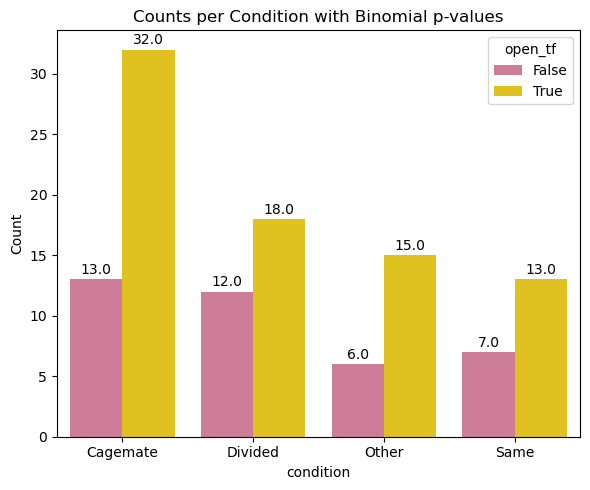

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

df = session_info_dataframe.copy()

conditions = sorted(df['condition'].astype(str).unique())

# Detect the unique hue values in a consistent order
hue_order = sorted(df['open_tf'].unique().tolist())

fig, ax = plt.subplots(figsize=(6,5))

sns.countplot(
    data=df,
    x='condition',
    hue='open_tf',
    order=conditions,
    hue_order=hue_order,
    palette=['palevioletred','gold'],
    ax=ax
)

# ----- Add raw counts above each bar -----
n_hues = len(hue_order)
patches = ax.patches

for i_cond, cond in enumerate(conditions):
    for j_hue, hue_val in enumerate(hue_order):

        patch_idx = i_cond * n_hues + j_hue
        patch = patches[patch_idx]
        height = patch.get_height()

        if height > 0:
            ax.text(
                patch.get_x() + patch.get_width()/2,
                height + max(0.2, height * 0.001),
                str(height),
                ha='center',
                va='bottom',
                fontsize=10
            )

ax.set_ylabel("Count")
ax.set_title("Counts per Condition with Binomial p-values")
plt.tight_layout()
plt.show()


<Axes: xlabel='free_rat', ylabel='count'>

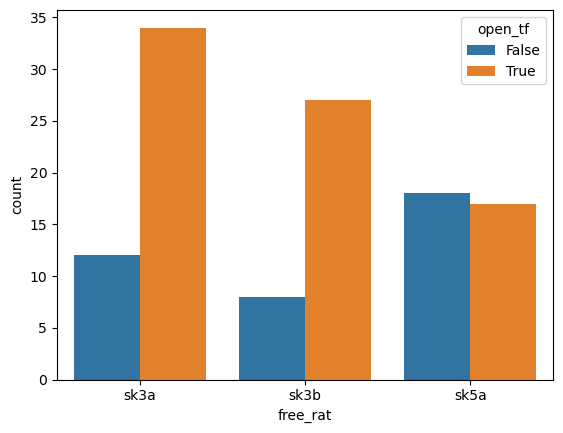

In [ ]:
sns.countplot(data=session_info_dataframe, x='free_rat', hue='open_tf')

<Axes: >

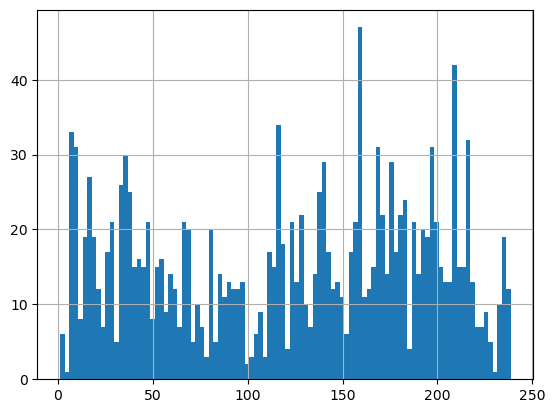

In [ ]:
no_open = usv_dataframe[usv_dataframe['before_open'] == 'No Open']
no_open['prox_to_trial_start'].hist(bins=100)

## Statistical Analyses

In [73]:
true_bins = rolling_density_df.loc[rolling_density_df['time_vs_open'] == 'During', 'density_zscore']
false_bins = rolling_density_df.loc[rolling_density_df['time_vs_open'] != 'During', 'density_zscore']

In [74]:
# Run two-sided Mann-Whitney U test (distributions are different)
u_stat, p_value = mannwhitneyu(true_bins, false_bins, alternative='two-sided')

print(f"Mann-Whitney U test (two-sided): U = {u_stat:.2f}, p = {p_value:.4f}")

# Run one-sided Mann-Whitney U test (true_bins > false_bins)
u_stat, p_value = mannwhitneyu(true_bins, false_bins, alternative='greater')

print(f"Mann-Whitney U test (one-sided): U = {u_stat:.2f}, p = {p_value:.4f}")

ks_stat, ks_p = ks_2samp(true_bins, false_bins)
print(f"Kolmogorov-Smirnov test: KS = {ks_stat:.3f}, p = {ks_p:.4f}")

Mann-Whitney U test (two-sided): U = 1398909256.50, p = 0.0000
Mann-Whitney U test (one-sided): U = 1398909256.50, p = 0.0000
Kolmogorov-Smirnov test: KS = 0.315, p = 0.0000


In [72]:
true_bins = rolling_density_df.loc[rolling_density_df['time_vs_open'] == 'During']['density_zscore']
false_bins = rolling_density_df.loc[rolling_density_df['time_vs_open'] == 'Before']['density_zscore']

In [63]:
# Run two-sided Mann-Whitney U test (distributions are different)
u_stat, p_value = mannwhitneyu(true_bins, false_bins, alternative='greater')

print(f"Mann-Whitney U test (two-sided): U = {u_stat:.2f}, p = {p_value:.4f}")

# Run one-sided Mann-Whitney U test (true_bins > false_bins)
u_stat, p_value = mannwhitneyu(true_bins, false_bins, alternative='greater')

print(f"Mann-Whitney U test (one-sided): U = {u_stat:.2f}, p = {p_value:.4f}")

ks_stat, ks_p = ks_2samp(true_bins, false_bins)
print(f"Kolmogorov-Smirnov test: KS = {ks_stat:.3f}, p = {ks_p:.4f}")

Mann-Whitney U test (two-sided): U = 231936596.00, p = 0.0000
Mann-Whitney U test (one-sided): U = 231936596.00, p = 0.0000
Kolmogorov-Smirnov test: KS = 0.073, p = 0.0000


In [64]:
true_bins.mean()

np.float64(0.29555597531313105)

In [65]:
false_bins.mean()

np.float64(0.26542632774989267)

In [67]:
def bootstrap_mean_diff_test(a, b, n_boot=10000, alternative="two-sided", random_state=None):
    rng = np.random.default_rng(random_state)
    
    a = np.asarray(a)
    b = np.asarray(b)
    
    # observed difference
    delta_obs = a.mean() - b.mean()
    
    # pooled data
    pooled = np.concatenate([a, b])
    n_a, n_b = len(a), len(b)
    
    # bootstrap distribution
    deltas = np.empty(n_boot)
    for i in range(n_boot):
        boot_a = rng.choice(pooled, size=n_a, replace=True)
        boot_b = rng.choice(pooled, size=n_b, replace=True)
        deltas[i] = boot_a.mean() - boot_b.mean()
    
    # compute p-value
    if alternative == "two-sided":
        pval = np.mean(np.abs(deltas) >= np.abs(delta_obs))
    elif alternative == "greater":
        pval = np.mean(deltas >= delta_obs)
    elif alternative == "less":
        pval = np.mean(deltas <= delta_obs)
    else:
        raise ValueError("alternative must be 'two-sided', 'greater', or 'less'")
    
    return delta_obs, deltas, pval

In [68]:
delta_obs, delta_boot, pval = bootstrap_mean_diff_test(
    true_bins,
    false_bins,
    n_boot=10000,
    alternative="greater",
    random_state=42
)

print("Observed Δ:", delta_obs)
print("Bootstrap p-value:", f"{pval:.10f}")

Observed Δ: 0.030129647563238382
Bootstrap p-value: 0.0000000000


## N-sizes

In [28]:
session_info_dataframe['restrainer_rat'].value_counts()

restrainer_rat
sk3b    25
sk3a    25
sk5b    25
sk1b    21
sk4a    10
sk2b    10
Name: count, dtype: int64

In [30]:
session_info_dataframe

trial_num  trial_start  lever_press  open_latency calls_before  \
0          1.0      72.4872     100.0210       27.5338         True   
1          2.0     467.0620       0.0000           NaN        False   
2          3.0     832.3360       0.0000           NaN        False   
3          4.0    1186.9790    1195.3590        8.3800        False   
4          5.0    1550.9490    1576.5490       25.6000         True   
..         ...          ...          ...           ...          ...   
111        1.0      99.5453     269.1443      169.5990         True   
112        2.0     465.3423     516.3413       50.9990         True   
113        3.0     816.1383       0.0000           NaN        False   
114        4.0    1191.7633       0.0000           NaN        False   
115        5.0    1548.1333       0.0000           NaN        False   

    calls_after                                           filename free_rat  \
0          True  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...     sk3a   
1         False  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...     sk3a   
2         False  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...     sk3a   
3         False  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...     sk3a   
4         False  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...     sk3a   
..          ...                                                ...      ...   
111       False  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...     sk5a   
112       False  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...     sk5a   
113       False  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...     sk5a   
114       False  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...     sk5a   
115       False  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...     sk5a   

    restrainer_rat condition  open_tf  
0             sk1b     Other     True  
1             sk1b     Other    False  
2             sk1b     Other    False  
3             sk1b     Other     True  
4             sk1b     Other     True  
..             ...       ...      ...  
111           sk2b      Same     True  
112           sk2b      Same     True  
113           sk2b      Same    False  
114           sk2b      Same    False  
115           sk2b      Same    False  

[116 rows x 11 columns]

In [33]:
from scipy.stats import binomtest

# if values are strings, normalize them
# session_info_dataframe['flag'] = session_info_dataframe['flag'].astype(str).str.lower().map({'true': True, 'false': False})

results = []

for cond, sub in session_info_dataframe.groupby('condition'):
    n = len(sub)
    k = sub['open_tf'].sum()  # count of True
    pval = binomtest(k, n, p=0.5, alternative='two-sided').pvalue
    
    results.append({
        'condition': cond,
        'n_total': n,
        'n_true': k,
        'n_false': n - k,
        'p_value': pval
    })

results_df = pd.DataFrame(results)
print(results_df)

  condition  n_total  n_true  n_false   p_value
0  Cagemate       45      32       13  0.006609
1   Divided       30      18       12  0.361595
2     Other       21      15        6  0.078354
3      Same       20      13        7  0.263176


In [35]:
with_lever_presses = session_info_dataframe[session_info_dataframe['open_tf'] == True]
results = []

for cond, sub in with_lever_presses.groupby('condition'):
    n = len(sub)
    k = sub['calls_before'].sum()  # count of True
    pval = binomtest(k, n, p=0.5, alternative='two-sided').pvalue
    
    results.append({
        'condition': cond,
        'n_total': n,
        'n_true': k,
        'n_false': n - k,
        'p_value': pval
    })

results_df = pd.DataFrame(results)
print(results_df)

  condition  n_total  n_true  n_false   p_value
0  Cagemate       32      28        4  0.000019
1   Divided       18      12        6  0.237885
2     Other       15       6        9  0.607239
3      Same       13      13        0  0.000244


In [37]:
from scipy.stats import chi2_contingency

cont = pd.crosstab(with_lever_presses['condition'], with_lever_presses['calls_before'])
chi2, p, dof, expected = chi2_contingency(cont)

print("Chi-square p-value:", p)
print("Expected counts:")
print(expected)

Chi-square p-value: 0.0004936328053593009
Expected counts:
[[ 7.79487179 24.20512821]
 [ 4.38461538 13.61538462]
 [ 3.65384615 11.34615385]
 [ 3.16666667  9.83333333]]


In [38]:
usv_dataframe 

start       stop     label  duration  trial_num  open_latency  \
4        78.2862    78.3462     USV_5     0.060          1       27.5338   
5        78.5122    78.5762     USV_6     0.064          1       27.5338   
6        78.7152    78.7882     USV_7     0.073          1       27.5338   
7        78.9562    79.0102     USV_8     0.054          1       27.5338   
8        79.1602    79.2392     USV_9     0.079          1       27.5338   
...          ...        ...       ...       ...        ...           ...   
24576  1761.0623  1761.0873  USV_1356     0.025          5           NaN   
24584  1774.1913  1774.2033  USV_1364     0.012          5           NaN   
24585  1774.3323  1774.3833  USV_1365     0.051          5           NaN   
24587  1774.5983  1774.6533  USV_1367     0.055          5           NaN   
24589  1774.8933  1774.9323  USV_1369     0.039          5           NaN   

      before_open       rms       zcr      centroid  ...  contrast7  \
4            True  0.012154  0.062744  19766.955446  ...  62.444193   
5            True  0.019320  0.072294  17615.508399  ...  64.026409   
6            True  0.020560  0.048950  16010.199582  ...  63.071369   
7            True  0.018967  0.068221  18687.963161  ...  62.284569   
8            True  0.013513  0.058693  18619.180378  ...  62.765954   
...           ...       ...       ...           ...  ...        ...   
24576     No Open  0.010492  0.026611  15785.677681  ...  48.994851   
24584     No Open  0.009105  0.018345  15018.715547  ...  45.107399   
24585     No Open  0.014581  0.053002  14651.318077  ...  59.715234   
24587     No Open  0.014686  0.044370  15035.218828  ...  58.621312   
24589     No Open  0.009771  0.052490  17455.368352  ...  56.198261   

       25_kHz_call  trial_start  lever_press  prox_to_trial_start  \
4                1      72.4872      100.021                5.799   
5                1      72.4872      100.021                6.025   
6                1      72.4872      100.021                6.228   
7                1      72.4872      100.021                6.469   
8                1      72.4872      100.021                6.673   
...            ...          ...          ...                  ...   
24576            1    1548.1333          NaN              212.929   
24584            1    1548.1333          NaN              226.058   
24585            1    1548.1333          NaN              226.199   
24587            1    1548.1333          NaN              226.465   
24589            1    1548.1333          NaN              226.760   

       prox_to_lever_press                                           filename  \
4                 -21.7348  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
5                 -21.5088  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
6                 -21.3058  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
7                 -21.0648  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
8                 -20.8608  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
...                    ...                                                ...   
24576                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
24584                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
24585                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
24587                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
24589                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   

       free_rat  restrainer_rat  condition  
4          sk3a            sk1b      Other  
5          sk3a            sk1b      Other  
6          sk3a            sk1b      Other  
7          sk3a            sk1b      Other  
8          sk3a            sk1b      Other  
...         ...             ...        ...  
24576      sk5a            sk2b       Same  
24584      sk5a            sk2b       Same  
24585      sk5a            sk2b       

In [39]:
before_open = usv_dataframe[usv_dataframe['before_open'].isin(['True', 'False'])]
before_open

start      stop    label  duration  trial_num  open_latency  \
4       78.2862   78.3462    USV_5     0.060          1       27.5338   
5       78.5122   78.5762    USV_6     0.064          1       27.5338   
6       78.7152   78.7882    USV_7     0.073          1       27.5338   
7       78.9562   79.0102    USV_8     0.054          1       27.5338   
8       79.1602   79.2392    USV_9     0.079          1       27.5338   
...         ...       ...      ...       ...        ...           ...   
23751  507.7643  507.8203  USV_531     0.056          2       50.9990   
23752  507.9103  507.9543  USV_532     0.044          2       50.9990   
23754  512.4853  512.5193  USV_534     0.034          2       50.9990   
23755  513.6123  513.6553  USV_535     0.043          2       50.9990   
23756  513.7473  513.7853  USV_536     0.038          2       50.9990   

      before_open       rms       zcr      centroid  ...  contrast7  \
4            True  0.012154  0.062744  19766.955446  ...  62.444193   
5            True  0.019320  0.072294  17615.508399  ...  64.026409   
6            True  0.020560  0.048950  16010.199582  ...  63.071369   
7            True  0.018967  0.068221  18687.963161  ...  62.284569   
8            True  0.013513  0.058693  18619.180378  ...  62.765954   
...           ...       ...       ...           ...  ...        ...   
23751        True  0.012320  0.045346  15851.406340  ...  60.902887   
23752        True  0.011152  0.048725  17813.229797  ...  57.193239   
23754        True  0.009470  0.042806  16430.364260  ...  55.103824   
23755        True  0.013425  0.026637  15809.438898  ...  57.053373   
23756        True  0.011184  0.037167  16786.994054  ...  56.968762   

       25_kHz_call  trial_start  lever_press  prox_to_trial_start  \
4                1      72.4872     100.0210                5.799   
5                1      72.4872     100.0210                6.025   
6                1      72.4872     100.0210                6.228   
7                1      72.4872     100.0210                6.469   
8                1      72.4872     100.0210                6.673   
...            ...          ...          ...                  ...   
23751            1     465.3423     516.3413               42.422   
23752            1     465.3423     516.3413               42.568   
23754            1     465.3423     516.3413               47.143   
23755            1     465.3423     516.3413               48.270   
23756            1     465.3423     516.3413               48.405   

       prox_to_lever_press                                           filename  \
4                 -21.7348  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
5                 -21.5088  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
6                 -21.3058  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
7                 -21.0648  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
8                 -20.8608  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
...                    ...                                                ...   
23751              -8.5770  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
23752              -8.4310  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
23754              -3.8560  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
23755              -2.7290  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
23756              -2.5940  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   

       free_rat  restrainer_rat  condition  
4          sk3a            sk1b      Other  
5          sk3a            sk1b      Other  
6          sk3a            sk1b      Other  
7          sk3a            sk1b      Other  
8          sk3a            sk1b      Other  
...         ...             ...        ...  
23751      sk5a            sk2b       Same  
23752      sk5a            sk2b       Same  
23754      sk5a            sk2b       Same  
23755      sk5a            s

In [43]:
from scipy.stats import binomtest

# convert to booleans: True = before, False = after
before_open = usv_dataframe[usv_dataframe['before_open'].isin(['True', 'False'])]
before_open['is_before'] = before_open['before_open'] == 'True'

n = len(before_open)
k = before_open['is_before'].sum()    # number of times A happened BEFORE B

# one-sided test: is before > 0.5?
pval = binomtest(k, n, p=0.01, alternative='greater').pvalue

print("Total events:", n)
print("Before:", k)
print("After:", n-k)
print(f"{pval:.20f}")


Total events: 2733
Before: 2357
After: 376
0.00000000000000000000


/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_13907/1479321856.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_open['is_before'] = before_open['before_open'] == 'True'


In [44]:
2357 / 2733

0.8624222466154409

In [45]:
with_lever_presses['open_latency'].mean()

np.float64(64.13873333333333)

In [47]:
usv_dataframe[(usv_dataframe['before_open'] == 'No Open') & (usv_dataframe['prox_to_trial_start'] < 60)]

start       stop     label  duration  trial_num  open_latency  \
3119    514.1520   514.2240     USV_7     0.072          1           NaN   
3120    514.3450   514.4400     USV_8     0.095          1           NaN   
3121    514.5500   514.6330     USV_9     0.083          1           NaN   
3130    520.6450   520.7130    USV_18     0.068          1           NaN   
3131    520.7960   520.9030    USV_19     0.107          1           NaN   
...          ...        ...       ...       ...        ...           ...   
24463  1556.7173  1556.7343  USV_1243     0.017          5           NaN   
24464  1556.8653  1556.8863  USV_1244     0.021          5           NaN   
24465  1557.1703  1557.1913  USV_1245     0.021          5           NaN   
24466  1557.3073  1557.3303  USV_1246     0.023          5           NaN   
24467  1557.4543  1557.4643  USV_1247     0.010          5           NaN   

      before_open       rms       zcr      centroid  ...  contrast7  \
3119      No Open  0.010458  0.030829  16366.746362  ...  59.656860   
3120      No Open  0.010206  0.044781  17038.517872  ...  62.993002   
3121      No Open  0.010261  0.037021  15671.081431  ...  60.154594   
3130      No Open  0.009802  0.044538  16693.057562  ...  59.978718   
3131      No Open  0.010769  0.045246  16140.366771  ...  62.818079   
...           ...       ...       ...           ...  ...        ...   
24463     No Open  0.013782  0.019206  13536.746582  ...  46.468583   
24464     No Open  0.012303  0.039966  14398.315535  ...  51.192432   
24465     No Open  0.014798  0.016895  14168.354075  ...  47.534991   
24466     No Open  0.015234  0.025213  15355.379658  ...  49.863720   
24467     No Open  0.010867  0.023397  16634.736427  ...  36.180044   

       25_kHz_call  trial_start  lever_press  prox_to_trial_start  \
3119             1     494.1600          NaN               19.992   
3120             1     494.1600          NaN               20.185   
3121             1     494.1600          NaN               20.390   
3130             1     494.1600          NaN               26.485   
3131             1     494.1600          NaN               26.636   
...            ...          ...          ...                  ...   
24463            1    1548.1333          NaN                8.584   
24464            1    1548.1333          NaN                8.732   
24465            1    1548.1333          NaN                9.037   
24466            1    1548.1333          NaN                9.174   
24467            1    1548.1333          NaN                9.321   

       prox_to_lever_press                                           filename  \
3119                   NaN  SK3aSK3b_Restrainer_Experiment_Cagemate_d1_s2_...   
3120                   NaN  SK3aSK3b_Restrainer_Experiment_Cagemate_d1_s2_...   
3121                   NaN  SK3aSK3b_Restrainer_Experiment_Cagemate_d1_s2_...   
3130                   NaN  SK3aSK3b_Restrainer_Experiment_Cagemate_d1_s2_...   
3131                   NaN  SK3aSK3b_Restrainer_Experiment_Cagemate_d1_s2_...   
...                    ...                                                ...   
24463                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
24464                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
24465                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
24466                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
24467                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   

       free_rat  restrainer_rat  condition  
3119       sk3a            sk3b   Cagemate  
3120       sk3a            sk3b   Cagemate  
3121       sk3a            sk3b   Cagemate  
3130       sk3a            sk3b   Cagemate  
3131       sk3a            sk3b   Cagemate  
...         ...             ...        ...  
24463      sk5a            sk2b       Same  
24464      sk5a            sk2b       Same  
24465      sk5a            sk2b       

In [48]:
usv_dataframe[(usv_dataframe['before_open'] == 'No Open') & (usv_dataframe['prox_to_trial_start'] > 180)]

start       stop     label  duration  trial_num  open_latency  \
3377    696.0840   696.1050   USV_265     0.021          1           NaN   
3925   1778.6700  1778.7070   USV_813     0.037          4           NaN   
3926   1778.8480  1778.8760   USV_814     0.028          4           NaN   
5097    733.6340   733.7100   USV_877     0.076          2           NaN   
5099    733.8500   733.9300   USV_879     0.080          2           NaN   
...          ...        ...       ...       ...        ...           ...   
24576  1761.0623  1761.0873  USV_1356     0.025          5           NaN   
24584  1774.1913  1774.2033  USV_1364     0.012          5           NaN   
24585  1774.3323  1774.3833  USV_1365     0.051          5           NaN   
24587  1774.5983  1774.6533  USV_1367     0.055          5           NaN   
24589  1774.8933  1774.9323  USV_1369     0.039          5           NaN   

      before_open       rms       zcr      centroid  ...  contrast7  \
3377      No Open  0.010289  0.012744  16487.234066  ...  49.154602   
3925      No Open  0.010215  0.023956  14879.674184  ...  55.095328   
3926      No Open  0.011191  0.025015  13685.048631  ...  52.384410   
5097      No Open  0.010643  0.049986  17987.933060  ...  59.583403   
5099      No Open  0.011790  0.023941  15473.937784  ...  59.774088   
...           ...       ...       ...           ...  ...        ...   
24576     No Open  0.010492  0.026611  15785.677681  ...  48.994851   
24584     No Open  0.009105  0.018345  15018.715547  ...  45.107399   
24585     No Open  0.014581  0.053002  14651.318077  ...  59.715234   
24587     No Open  0.014686  0.044370  15035.218828  ...  58.621312   
24589     No Open  0.009771  0.052490  17455.368352  ...  56.198261   

       25_kHz_call  trial_start  lever_press  prox_to_trial_start  \
3377             1     494.1600          NaN              201.924   
3925             1    1550.7100          NaN              227.960   
3926             1    1550.7100          NaN              228.138   
5097             1     539.0750          NaN              194.559   
5099             1     539.0750          NaN              194.775   
...            ...          ...          ...                  ...   
24576            1    1548.1333          NaN              212.929   
24584            1    1548.1333          NaN              226.058   
24585            1    1548.1333          NaN              226.199   
24587            1    1548.1333          NaN              226.465   
24589            1    1548.1333          NaN              226.760   

       prox_to_lever_press                                           filename  \
3377                   NaN  SK3aSK3b_Restrainer_Experiment_Cagemate_d1_s2_...   
3925                   NaN  SK3aSK3b_Restrainer_Experiment_Cagemate_d1_s2_...   
3926                   NaN  SK3aSK3b_Restrainer_Experiment_Cagemate_d1_s2_...   
5097                   NaN  SK3aSK3b_Restrainer_Experiment_Divided_d3_s1_0...   
5099                   NaN  SK3aSK3b_Restrainer_Experiment_Divided_d3_s1_0...   
...                    ...                                                ...   
24576                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
24584                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
24585                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
24587                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
24589                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   

       free_rat  restrainer_rat  condition  
3377       sk3a            sk3b   Cagemate  
3925       sk3a            sk3b   Cagemate  
3926       sk3a            sk3b   Cagemate  
5097       sk3a            sk3b    Divided  
5099       sk3a            sk3b    Divided  
...         ...             ...        ...  
24576      sk5a            sk2b       Same  
24584      sk5a            sk2b       Same  
24585      sk5a            sk2b       

In [50]:
usv_dataframe[(usv_dataframe['before_open'] != 'No Open')]

start      stop    label  duration  trial_num  open_latency  \
4       78.2862   78.3462    USV_5     0.060          1       27.5338   
5       78.5122   78.5762    USV_6     0.064          1       27.5338   
6       78.7152   78.7882    USV_7     0.073          1       27.5338   
7       78.9562   79.0102    USV_8     0.054          1       27.5338   
8       79.1602   79.2392    USV_9     0.079          1       27.5338   
...         ...       ...      ...       ...        ...           ...   
23751  507.7643  507.8203  USV_531     0.056          2       50.9990   
23752  507.9103  507.9543  USV_532     0.044          2       50.9990   
23754  512.4853  512.5193  USV_534     0.034          2       50.9990   
23755  513.6123  513.6553  USV_535     0.043          2       50.9990   
23756  513.7473  513.7853  USV_536     0.038          2       50.9990   

      before_open       rms       zcr      centroid  ...  contrast7  \
4            True  0.012154  0.062744  19766.955446  ...  62.444193   
5            True  0.019320  0.072294  17615.508399  ...  64.026409   
6            True  0.020560  0.048950  16010.199582  ...  63.071369   
7            True  0.018967  0.068221  18687.963161  ...  62.284569   
8            True  0.013513  0.058693  18619.180378  ...  62.765954   
...           ...       ...       ...           ...  ...        ...   
23751        True  0.012320  0.045346  15851.406340  ...  60.902887   
23752        True  0.011152  0.048725  17813.229797  ...  57.193239   
23754        True  0.009470  0.042806  16430.364260  ...  55.103824   
23755        True  0.013425  0.026637  15809.438898  ...  57.053373   
23756        True  0.011184  0.037167  16786.994054  ...  56.968762   

       25_kHz_call  trial_start  lever_press  prox_to_trial_start  \
4                1      72.4872     100.0210                5.799   
5                1      72.4872     100.0210                6.025   
6                1      72.4872     100.0210                6.228   
7                1      72.4872     100.0210                6.469   
8                1      72.4872     100.0210                6.673   
...            ...          ...          ...                  ...   
23751            1     465.3423     516.3413               42.422   
23752            1     465.3423     516.3413               42.568   
23754            1     465.3423     516.3413               47.143   
23755            1     465.3423     516.3413               48.270   
23756            1     465.3423     516.3413               48.405   

       prox_to_lever_press                                           filename  \
4                 -21.7348  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
5                 -21.5088  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
6                 -21.3058  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
7                 -21.0648  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
8                 -20.8608  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
...                    ...                                                ...   
23751              -8.5770  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
23752              -8.4310  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
23754              -3.8560  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
23755              -2.7290  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
23756              -2.5940  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   

       free_rat  restrainer_rat  condition  
4          sk3a            sk1b      Other  
5          sk3a            sk1b      Other  
6          sk3a            sk1b      Other  
7          sk3a            sk1b      Other  
8          sk3a            sk1b      Other  
...         ...             ...        ...  
23751      sk5a            sk2b       Same  
23752      sk5a            sk2b       Same  
23754      sk5a            sk2b       Same  
23755      sk5a            s

In [17]:
usv_dataframe

start       stop     label  duration  trial_num  open_latency  \
4        78.2862    78.3462     USV_5     0.060          1       27.5338   
5        78.5122    78.5762     USV_6     0.064          1       27.5338   
6        78.7152    78.7882     USV_7     0.073          1       27.5338   
7        78.9562    79.0102     USV_8     0.054          1       27.5338   
8        79.1602    79.2392     USV_9     0.079          1       27.5338   
...          ...        ...       ...       ...        ...           ...   
24576  1761.0623  1761.0873  USV_1356     0.025          5           NaN   
24584  1774.1913  1774.2033  USV_1364     0.012          5           NaN   
24585  1774.3323  1774.3833  USV_1365     0.051          5           NaN   
24587  1774.5983  1774.6533  USV_1367     0.055          5           NaN   
24589  1774.8933  1774.9323  USV_1369     0.039          5           NaN   

      before_open       rms       zcr      centroid  ...  contrast7  \
4            True  0.012154  0.062744  19766.955446  ...  62.444193   
5            True  0.019320  0.072294  17615.508399  ...  64.026409   
6            True  0.020560  0.048950  16010.199582  ...  63.071369   
7            True  0.018967  0.068221  18687.963161  ...  62.284569   
8            True  0.013513  0.058693  18619.180378  ...  62.765954   
...           ...       ...       ...           ...  ...        ...   
24576     No Open  0.010492  0.026611  15785.677681  ...  48.994851   
24584     No Open  0.009105  0.018345  15018.715547  ...  45.107399   
24585     No Open  0.014581  0.053002  14651.318077  ...  59.715234   
24587     No Open  0.014686  0.044370  15035.218828  ...  58.621312   
24589     No Open  0.009771  0.052490  17455.368352  ...  56.198261   

       25_kHz_call  trial_start  lever_press  prox_to_trial_start  \
4                1      72.4872      100.021                5.799   
5                1      72.4872      100.021                6.025   
6                1      72.4872      100.021                6.228   
7                1      72.4872      100.021                6.469   
8                1      72.4872      100.021                6.673   
...            ...          ...          ...                  ...   
24576            1    1548.1333          NaN              212.929   
24584            1    1548.1333          NaN              226.058   
24585            1    1548.1333          NaN              226.199   
24587            1    1548.1333          NaN              226.465   
24589            1    1548.1333          NaN              226.760   

       prox_to_lever_press                                           filename  \
4                 -21.7348  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
5                 -21.5088  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
6                 -21.3058  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
7                 -21.0648  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
8                 -20.8608  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
...                    ...                                                ...   
24576                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
24584                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
24585                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
24587                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
24589                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   

       free_rat  restrainer_rat  condition  
4          sk3a            sk1b      Other  
5          sk3a            sk1b      Other  
6          sk3a            sk1b      Other  
7          sk3a            sk1b      Other  
8          sk3a            sk1b      Other  
...         ...             ...        ...  
24576      sk5a            sk2b       Same  
24584      sk5a            sk2b       Same  
24585      sk5a            sk2b       

In [ ]:
temp2 = usv_dataframe.copy()
temp2['condition2'] = temp2['condition'].replace({'Divided': 'Cagemate', 'Same': 'Other'})
temp2 = temp2[temp2['before_open'] != 'No Open']

In [25]:
temp2.groupby(['condition2'])['before_open'].value_counts(normalize=True)

condition2  before_open
Cagemate    True           0.830256
            False          0.169744
Other       True           0.913662
            False          0.086338
Name: proportion, dtype: float64

In [ ]:
temp2.groupby(['condition'])['']

filename  trial_num before_open  \
0   SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...          1       False   
1   SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...          1        True   
2   SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...          5        True   
3   SK3aSK1b_Restrainer_Experiment_Other_d6_s2_062...          1       False   
4   SK3aSK1b_Restrainer_Experiment_Other_d6_s2_062...          1        True   
..                                                ...        ...         ...   
74  SK5aSK5b_Restrainer_Experiment_Divided_d5_s1_0...          4       False   
75  SK5aSK5b_Restrainer_Experiment_Divided_d5_s1_0...          4        True   
76  SK5aSK5b_Restrainer_Experiment_Divided_d5_s2_0...          2        True   
77  SK5aSK5b_Restrainer_Experiment_Divided_d5_s2_0...          4        True   
78  Sk5aSK5b_Restrainer_Experiment_Cagemate_d2_s1_...          1        True   

    open_latency  count  relative_density  
0        27.5338     10          0.047066  
1        27.5338     22          0.799018  
2        25.6000      4          0.156250  
3        40.3510      1          0.005009  
4        40.3510      5          0.123913  
..           ...    ...               ...  
74       59.5700      5          0.027712  
75       59.5700      3          0.050361  
76      185.4540     47          0.253432  
77       31.7000      3          0.094637  
78      133.9530     71          0.530037  

[79 rows x 6 columns]

In [31]:
temp3 = session_info_dataframe.copy()
temp3['condition2'] = temp3['condition'].replace({'Divided': 'Cagemate', 'Same': 'Stranger', 'Other': 'Stranger'})

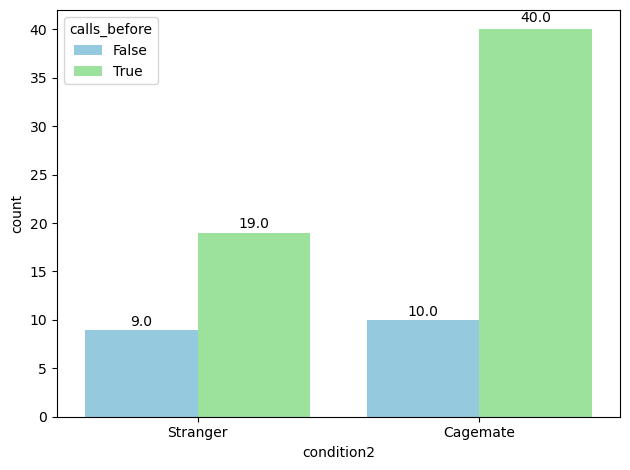

In [32]:
ax = sns.countplot(
    data=temp3[temp3['open_tf'] == True],
    x='condition2',
    hue='calls_before',
    palette=['skyblue', 'lightgreen']
)

# Add counts above bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + 0.01 * height,   # slight offset
            str(height),
            ha='center',
            va='bottom',
            fontsize=10
        )

plt.tight_layout()
plt.show()

In [33]:
from scipy.stats import chi2_contingency

cont = pd.crosstab(temp3['condition2'], temp3['calls_before'])
chi2, p, dof, expected = chi2_contingency(cont)

print("Chi-square p-value:", p)
print("Expected counts:")
print(expected)

Chi-square p-value: 0.6889894949497952
Expected counts:
[[36.52173913 38.47826087]
 [19.47826087 20.52173913]]


In [35]:
call_density['condition'] = call_density['filename'].apply(lambda x: x.strip().split('_')[3])

In [37]:
call_density['condition'] = call_density['condition'].replace({'Divided': 'Cagemate', 'Same': 'Stranger', 'Other': 'Stranger'})

In [39]:
usv_dataframe

start       stop     label  duration  trial_num  open_latency  \
4        78.2862    78.3462     USV_5     0.060          1       27.5338   
5        78.5122    78.5762     USV_6     0.064          1       27.5338   
6        78.7152    78.7882     USV_7     0.073          1       27.5338   
7        78.9562    79.0102     USV_8     0.054          1       27.5338   
8        79.1602    79.2392     USV_9     0.079          1       27.5338   
...          ...        ...       ...       ...        ...           ...   
24576  1761.0623  1761.0873  USV_1356     0.025          5           NaN   
24584  1774.1913  1774.2033  USV_1364     0.012          5           NaN   
24585  1774.3323  1774.3833  USV_1365     0.051          5           NaN   
24587  1774.5983  1774.6533  USV_1367     0.055          5           NaN   
24589  1774.8933  1774.9323  USV_1369     0.039          5           NaN   

      before_open       rms       zcr      centroid  ...  contrast7  \
4            True  0.012154  0.062744  19766.955446  ...  62.444193   
5            True  0.019320  0.072294  17615.508399  ...  64.026409   
6            True  0.020560  0.048950  16010.199582  ...  63.071369   
7            True  0.018967  0.068221  18687.963161  ...  62.284569   
8            True  0.013513  0.058693  18619.180378  ...  62.765954   
...           ...       ...       ...           ...  ...        ...   
24576     No Open  0.010492  0.026611  15785.677681  ...  48.994851   
24584     No Open  0.009105  0.018345  15018.715547  ...  45.107399   
24585     No Open  0.014581  0.053002  14651.318077  ...  59.715234   
24587     No Open  0.014686  0.044370  15035.218828  ...  58.621312   
24589     No Open  0.009771  0.052490  17455.368352  ...  56.198261   

       25_kHz_call  trial_start  lever_press  prox_to_trial_start  \
4                1      72.4872      100.021                5.799   
5                1      72.4872      100.021                6.025   
6                1      72.4872      100.021                6.228   
7                1      72.4872      100.021                6.469   
8                1      72.4872      100.021                6.673   
...            ...          ...          ...                  ...   
24576            1    1548.1333          NaN              212.929   
24584            1    1548.1333          NaN              226.058   
24585            1    1548.1333          NaN              226.199   
24587            1    1548.1333          NaN              226.465   
24589            1    1548.1333          NaN              226.760   

       prox_to_lever_press                                           filename  \
4                 -21.7348  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
5                 -21.5088  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
6                 -21.3058  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
7                 -21.0648  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
8                 -20.8608  SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...   
...                    ...                                                ...   
24576                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
24584                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
24585                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
24587                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   
24589                  NaN  SK5aSK2b_Restrainer_Experiment_Same_d3_s1_0417...   

       free_rat  restrainer_rat  condition  
4          sk3a            sk1b      Other  
5          sk3a            sk1b      Other  
6          sk3a            sk1b      Other  
7          sk3a            sk1b      Other  
8          sk3a            sk1b      Other  
...         ...             ...        ...  
24576      sk5a            sk2b       Same  
24584      sk5a            sk2b       Same  
24585      sk5a            sk2b       

In [49]:
num_per_trial = usv_dataframe.groupby(['filename', 'trial_num', 'before_open', 'open_latency'])['25_kHz_call'].sum().reset_index()

In [50]:
num_per_trial['condition'] = num_per_trial['filename'].apply(lambda x: x.strip().split('_')[3])
num_per_trial['condition'] = num_per_trial['condition'].replace({'Divided': 'Cagemate', 'Same': 'Stranger', 'Other': 'Stranger', 'Cagemate2': 'Cagemate'})

In [51]:
num_per_trial

filename  trial_num before_open  \
0   SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...          1       False   
1   SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...          1        True   
2   SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...          5        True   
3   SK3aSK1b_Restrainer_Experiment_Other_d6_s2_062...          1       False   
4   SK3aSK1b_Restrainer_Experiment_Other_d6_s2_062...          1        True   
..                                                ...        ...         ...   
85  SK5aSK5b_Restrainer_Experiment_Divided_d5_s1_0...          4        True   
86  SK5aSK5b_Restrainer_Experiment_Divided_d5_s2_0...          1        True   
87  SK5aSK5b_Restrainer_Experiment_Divided_d5_s2_0...          2        True   
88  SK5aSK5b_Restrainer_Experiment_Divided_d5_s2_0...          4        True   
89  Sk5aSK5b_Restrainer_Experiment_Cagemate_d2_s1_...          1        True   

    open_latency  25_kHz_call condition  
0        27.5338           10  Stranger  
1        27.5338           22  Stranger  
2        25.6000            4  Stranger  
3        40.3510            1  Stranger  
4        40.3510            5  Stranger  
..           ...          ...       ...  
85       59.5700            3  Cagemate  
86       17.0170            4  Cagemate  
87      185.4540           47  Cagemate  
88       31.7000            3  Cagemate  
89      133.9530           71  Cagemate  

[90 rows x 6 columns]

In [52]:
num_per_trial['density'] = num_per_trial.apply(
    lambda row: row['25_kHz_call'] / (row['open_latency'] if row['before_open'] == 'True' else (240 - row['open_latency'])),
    axis=1
)

In [53]:
num_per_trial

filename  trial_num before_open  \
0   SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...          1       False   
1   SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...          1        True   
2   SK3aSK1b_Restrainer_Experiment_Other_d6_s1_062...          5        True   
3   SK3aSK1b_Restrainer_Experiment_Other_d6_s2_062...          1       False   
4   SK3aSK1b_Restrainer_Experiment_Other_d6_s2_062...          1        True   
..                                                ...        ...         ...   
85  SK5aSK5b_Restrainer_Experiment_Divided_d5_s1_0...          4        True   
86  SK5aSK5b_Restrainer_Experiment_Divided_d5_s2_0...          1        True   
87  SK5aSK5b_Restrainer_Experiment_Divided_d5_s2_0...          2        True   
88  SK5aSK5b_Restrainer_Experiment_Divided_d5_s2_0...          4        True   
89  Sk5aSK5b_Restrainer_Experiment_Cagemate_d2_s1_...          1        True   

    open_latency  25_kHz_call condition   density  
0        27.5338           10  Stranger  0.047066  
1        27.5338           22  Stranger  0.799018  
2        25.6000            4  Stranger  0.156250  
3        40.3510            1  Stranger  0.005009  
4        40.3510            5  Stranger  0.123913  
..           ...          ...       ...       ...  
85       59.5700            3  Cagemate  0.050361  
86       17.0170            4  Cagemate  0.235059  
87      185.4540           47  Cagemate  0.253432  
88       31.7000            3  Cagemate  0.094637  
89      133.9530           71  Cagemate  0.530037  

[90 rows x 7 columns]

<Axes: xlabel='condition', ylabel='density'>

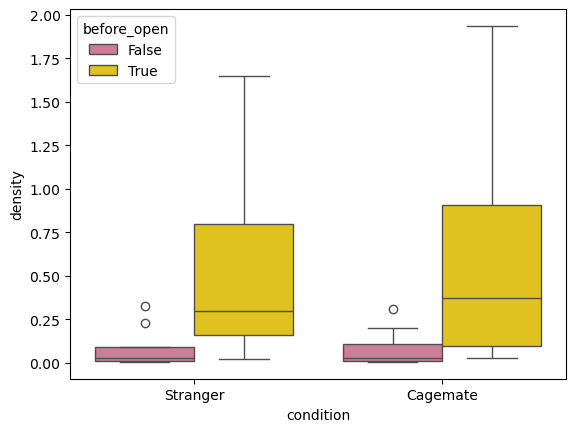

In [60]:
sns.boxplot(data=num_per_trial, x='condition', y='density', hue='before_open', palette=['palevioletred','gold'])

In [57]:
u, p = mannwhitneyu(
    num_per_trial[num_per_trial['condition'] == 'Cagemate']['density'],
    num_per_trial[num_per_trial['condition'] == 'Stranger']['density'],
    alternative='greater'  # A > B
)

In [58]:
u, p

(np.float64(782.0), np.float64(0.7282499775778222))

In [ ]:
def permutation_pvalue(x, y, n_perm=10000):
    obs = np.mean(x) - np.mean(y)
    combined = np.concatenate([x, y])
    count = 0
    for _ in range(n_perm):
        np.random.shuffle(combined)
        new_x = combined[:len(x)]
        new_y = combined[len(x):]
        if (np.mean(new_x) - np.mean(new_y)) >= obs:
            count += 1
    return count / n_perm

p = permutation_pvalue(
    df[df.condition=='A']['call_rate'].values,
    df[df.condition=='B']['call_rate'].values
)